# Feature Engineering Notebook

This notebook takes the reconfigured files from the first notebook and explores the data.  We create new features and get the data in the proper format for analysis.  

In [244]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import boxcox
from scipy import stats
import datatools

%matplotlib inline

In [245]:
#Bring in the data

nba = pd.read_csv('./data/nba_combined.csv')
nba.dropna(inplace = True)

In [246]:
#bring in test data 
nba_test = pd.read_csv('./data/nba_test.csv')

## Look at the Data

Let us look at the Distribution of the win margins that we will try and predict as well as how well the line does in separating the data.

To do this we want to look at the distribution of final scores.  We look at the average home win Margin of NBA teams.  We can see that the home team wins by an average of 3.1 point with a standard deviation of 13.  We can assume with this data that the average home court advantage would add 3.1 points to the home team scores.


In [247]:
print('The standard deviation of the Win Margins is ',np.std(nba.home_win_margin))
print('The mean home winning margin is ', nba.home_win_margin.mean())

The standard deviation of the Win Margins is  13.362387181118889
The mean home winning margin is  3.02041992589543


In [248]:
graph = datatools.DataGrapher()

Let Graph


In [249]:
graph.getdata(nba)

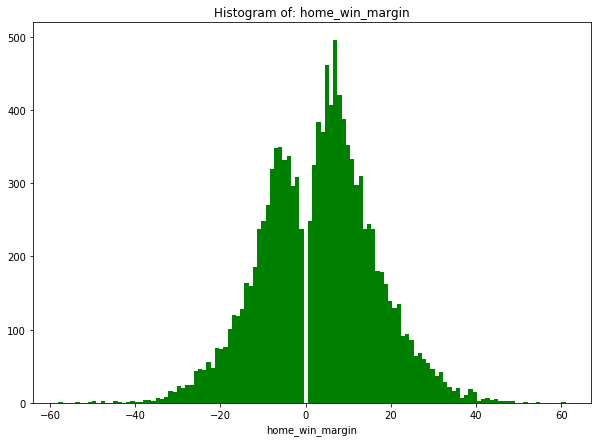

In [250]:
graph.plothist('home_win_margin', bins = 120)


We also want to look at the value of the points throughout the dataset. As line shopping can be an important factor in final win percentage.  We see that the home team winning by 7 is the most common occurrence landing about 4 percent of the time.  Line shopping can drastically change one's winning percentage. 

In [251]:
nba.home_win_margin.value_counts(normalize= True)

 7.0     0.040758
 5.0     0.037958
 8.0     0.034582
 6.0     0.033512
 9.0     0.031947
 3.0     0.031618
 4.0     0.030465
 10.0    0.028983
-6.0     0.028818
-7.0     0.028654
-4.0     0.027748
 11.0    0.027419
-5.0     0.027336
 2.0     0.026760
-8.0     0.026266
 13.0    0.025525
-2.0     0.025360
 12.0    0.024455
-3.0     0.024372
-9.0     0.022231
-10.0    0.020502
 1.0     0.020420
 15.0    0.020091
-1.0     0.019597
-11.0    0.019514
 14.0    0.019514
 16.0    0.019514
-12.0    0.015233
 17.0    0.014821
 18.0    0.014739
           ...   
-33.0    0.000659
-35.0    0.000576
 43.0    0.000576
 37.0    0.000576
 45.0    0.000494
 42.0    0.000494
-34.0    0.000494
-38.0    0.000329
-37.0    0.000329
 44.0    0.000329
-41.0    0.000247
 49.0    0.000247
-50.0    0.000165
 41.0    0.000165
-45.0    0.000165
-48.0    0.000165
-36.0    0.000165
 46.0    0.000165
 48.0    0.000165
 47.0    0.000165
-51.0    0.000082
-40.0    0.000082
-39.0    0.000082
-54.0    0.000082
 61.0    0

### Difference Between Actual Result and the Line

Line_cv is the home winning margin plus the line.  It is an indication of how far off the line  makers are from the actual result.  With a mean of -.2 The bookmakers have a very slight bias for the home team.  This is expected as the average better generally likes to bet favorites which most often are the home team. The bias is not big enough to make betting away team profitable.

In [252]:
print('The standard deviation of bookmaker errors ',np.std(nba.line_cv))
print('The mean of bookmaker errors', nba.line_cv.mean())

The standard deviation of bookmaker errors  11.910180196165754
The mean of bookmaker errors -0.1688719637710992


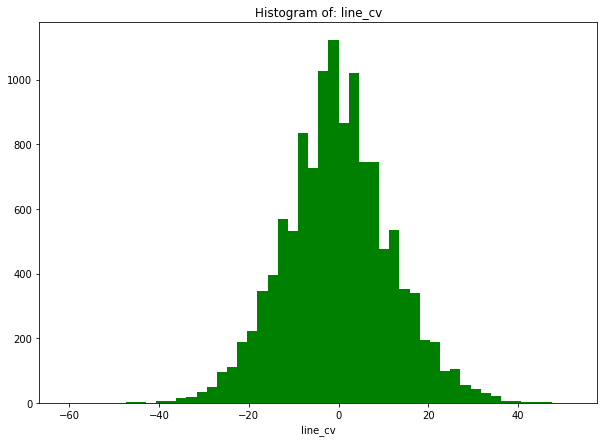

In [253]:
graph.plothist('line_cv')

The Error from the line is pretty normally distributed around zero.  With a mean of -.2 and standard deviation of 11.  The standard deviation is high but that is to be expected.  Anyone that has ever watch an NBA game knows that there is large variance at the end of games with teams fouling and shooting with irregularity based on no real reason other than that games characteristics

### Covers

Here we look at the actual variable of interest did a team cover the spread or not.  It is complicated by the inclusion of pushes.  If the game lands on the number neither the bettor or the house wins.  This occurs in about 2% of cases.  However, it complicates the analysis as we group the ties in with the null class. We do create a new payout variable that we will use to measure success that does take into account the ties. 

In [254]:
nba.cover.value_counts()

0    6310
1    5835
Name: cover, dtype: int64

In [255]:
nba.cover.value_counts(normalize = True)

0    0.519555
1    0.480445
Name: cover, dtype: float64

In [256]:
nba.away_cover.value_counts(normalize = True)

0    0.5007
1    0.4993
Name: away_cover, dtype: float64

When we look at the away covers we can see the number of pushes is just under 2%. Currently pushes are considered losses but the values need to be recalibrated to 0 since a push is equivalent to a no bet.

The actual ratio of away to home covers would be 

         .48 / .48 + 50 = 49% 
    
Leaving 51% of away teams to cover since we need 52.38% to cover it away games might provide us with more value

### Calulate returns to account for pushes

In reality this is a multinomial categorization problem as there is a push class.  It is roughly 2% of the data.  However, I am uninterested in the push class.  However, I calculate the payout since I am combining it with the negative class. I can get a better idea of the payout by subtracting out the pushes at the end of the analysis

In [257]:
# add training payouts of .909, -1 and 0 respectively
conditions = [
    (nba['line_cv'] <0), 
    (nba['line_cv'] > 0),
    (nba['line_cv'] == 0)]
choices = [.909, -1, 0]
nba['away_payout'] = np.select(conditions, choices)

In [258]:
print(nba.away_payout.value_counts())
print(nba.away_cover.value_counts())

 0.909    6064
-1.000    5835
 0.000     246
Name: away_payout, dtype: int64
0    6081
1    6064
Name: away_cover, dtype: int64


In [259]:
conditions = [
    (nba['line_cv'] >0), 
    (nba['line_cv'] < 0),
    (nba['line_cv'] == 0)]
choices = [.909, -1, 0]
nba['home_payout'] = np.select(conditions, choices)

In [260]:
print(nba.home_payout.value_counts())
print(nba.cover.value_counts())

-1.000    6064
 0.909    5835
 0.000     246
Name: home_payout, dtype: int64
0    6310
1    5835
Name: cover, dtype: int64


Value count numbers match up nicely

### Look at Correlation Heat Map

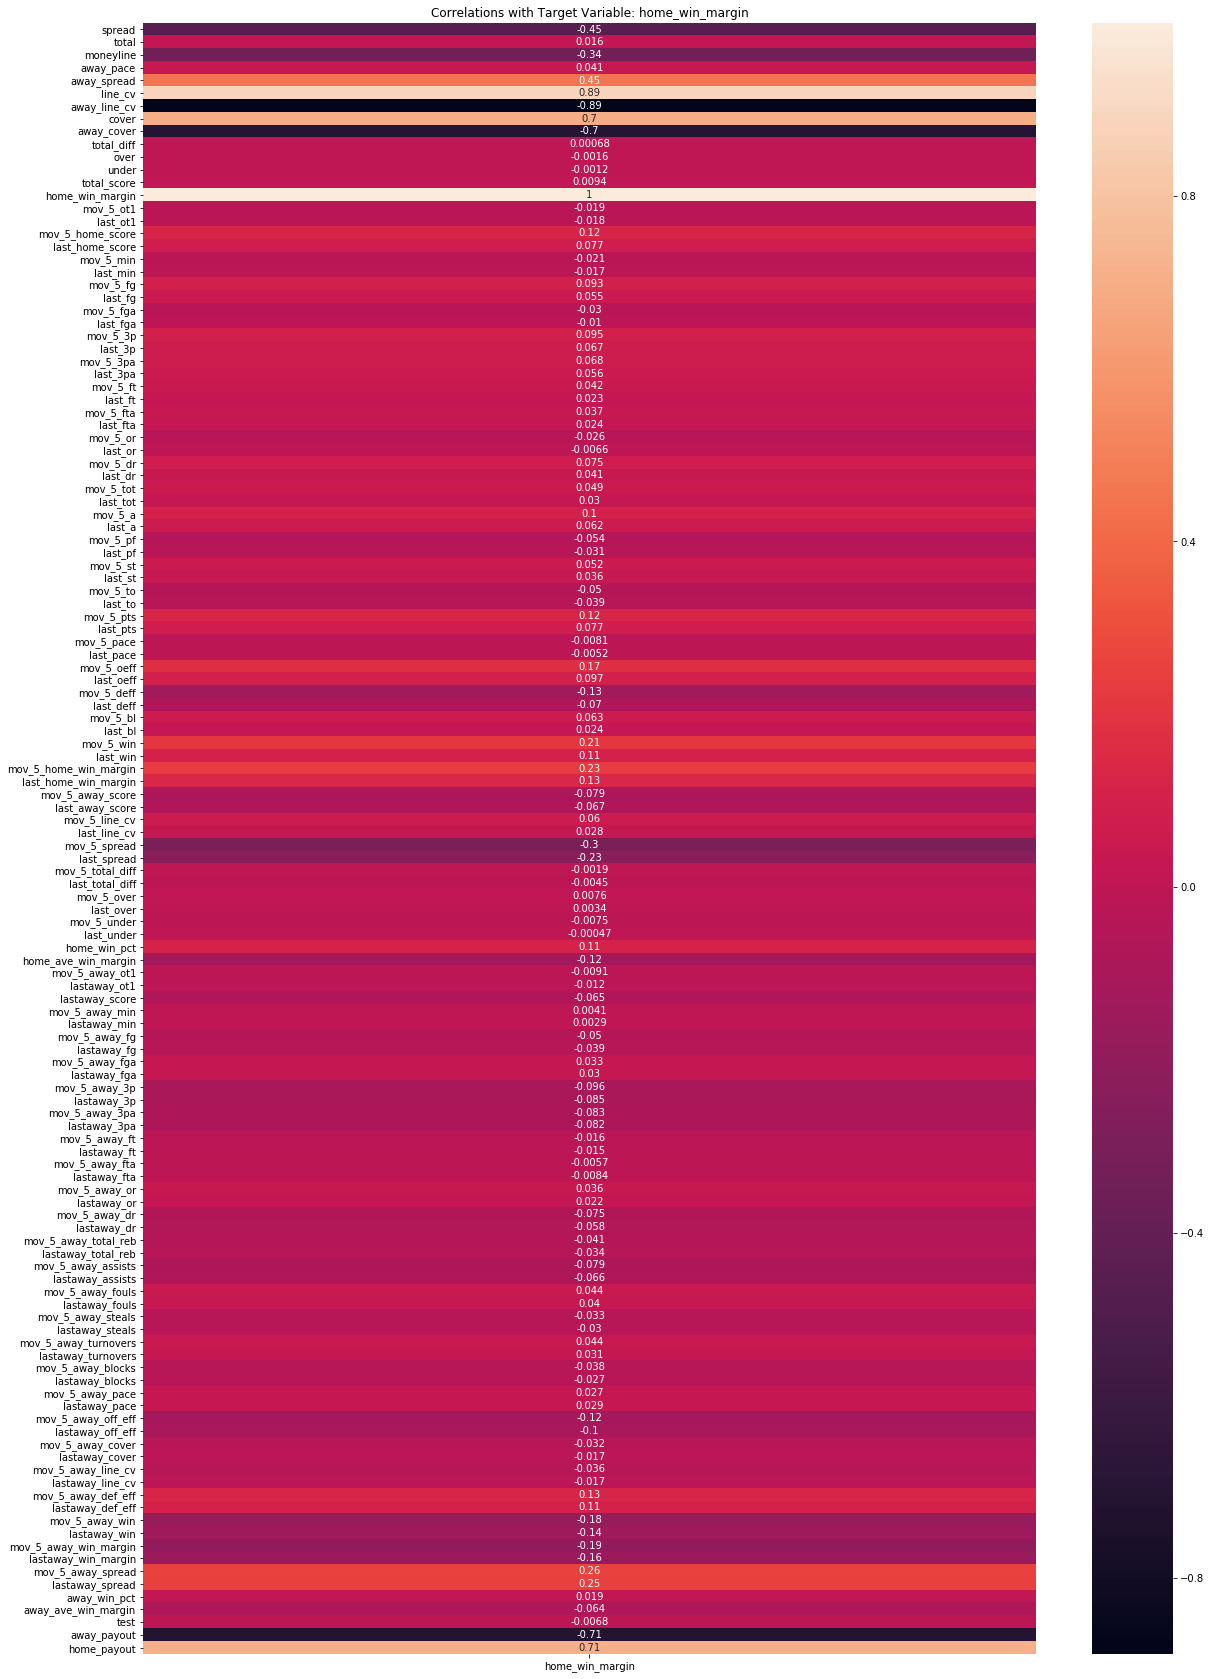

In [261]:
graph.plotheatc('home_win_margin')

Most of the correlations are small but I am looking for small edges so including variables may have some positive impact.  

#### Spread 

One would expect the spread to be a predictor of home win margin as it is the line the books put out to divide the action.  The spread should move with the actual win margin.

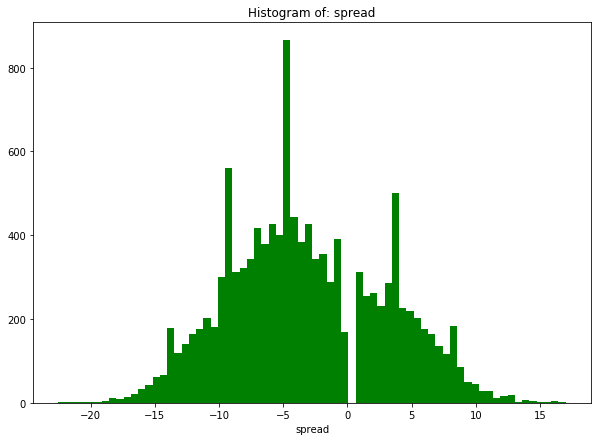

In [262]:
graph.plothist('spread', bins = 70)

In [263]:
print('The standard deviation of spread ',np.std(nba.spread))
print('The mean of spread', nba.spread.mean())

The standard deviation of spread  6.1503234369241016
The mean of spread -3.189291889666529


You will notice here that the mean spread is -3.27 and the standard deviation is 6.1.  Compare that to the home win margin information. 
The home_win_margin had a mean of 3.03 almost the inverse of the spread but a larger standard deviation of 13.  This shows us that the spread is centered on the average win value but does not move as much.  They err towards the center. Suggesting that the spread is calculated by using a formula that compiles many results to cut down on variance.

/Users/bryancombs/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


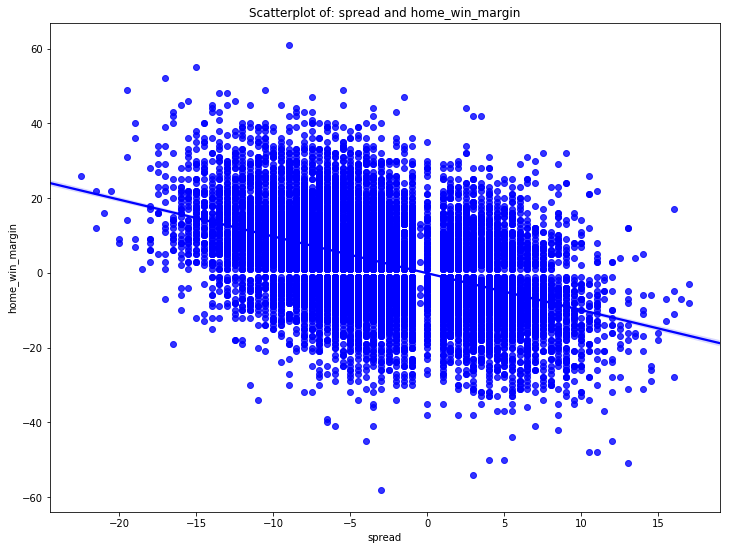

In [264]:
graph.plotscat('spread', 'home_win_margin')

In [265]:
nba.home_win_margin.corr(nba.spread)
#strong negative correlation as expected since line is opposite of win
#margin

-0.4534239105587527

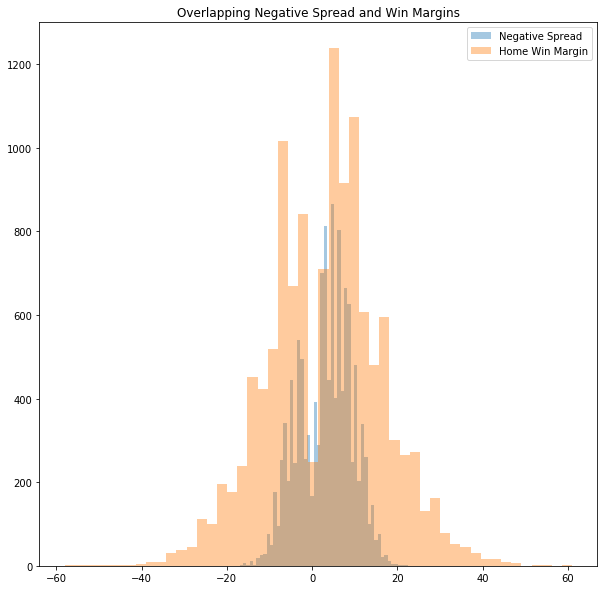

In [266]:
fig = plt.figure(figsize= (10,10))
plt.hist(-nba.spread, bins=50, alpha=0.4, label='Negative Spread')
plt.hist(nba.home_win_margin, bins=50, alpha=0.4, label='Home Win Margin')
plt.legend(loc='upper right')
plt.title("Overlapping Negative Spread and Win Margins")
plt.show()

### High Altitiude Dummy

There are two Western Conference Teams that play at high altitude.  These games are tougher for some away teams especially coming off of a long road trip.  We create a dummy to account for the travel.  

In [267]:
nba['high_alt'] = nba.teams.map(lambda x: 1 if (x == "Denver") or 
                                (x== "Utah") else 0)

nba_test['high_alt'] = nba.teams.map(lambda x: 1 if (x == "Denver") or 
                                (x== "Utah") else 0)

### Changing Rest Features to Dummies

The NBA schedule is not fixed and many teams have a different amount or rest entering games.  Last season they changed some rules and started the season earlier to make the season less taxing, but it is still important to account for the various

We will create a variable for each.  This will greatly expand our number of features as will future dummying that is, but the plan is to do feature extraction using Principal Components analysis so the feature increase should not be too onerous on the model.


In [268]:
nba = pd.get_dummies(nba , columns= ['away_rest', 'rest_days'], drop_first= True)
nba_test = pd.get_dummies(nba_test , columns= ['away_rest', 'rest_days'], drop_first= True)

### Teams Dummies

It is also important to distinguish between teams teams venues and support might influence the outcomes of games.  Here we dummy teams accomplish that goal.



In [269]:
#nba = nba = pd.get_dummies(nba, columns = ['teams', 'away_team'], drop_first = True)

### Referee Dummies 

The final dummy conversions are for the referee information.  Three referees generally work an NBA game.  We have the values for each and will convert them to dummies to incorporate any referee tendencies. 

In the end these variables added a great deal of noise without any predictive value so they were excluded.  

In [270]:
#nba = pd.get_dummies(nba, columns = ['ref_1','crew_referees','ref_3'], drop_first = True)

### Cumulative Stats Variables

There are for cumulative stats variable we generated Average win margin and Average win percentage for both home and away variables

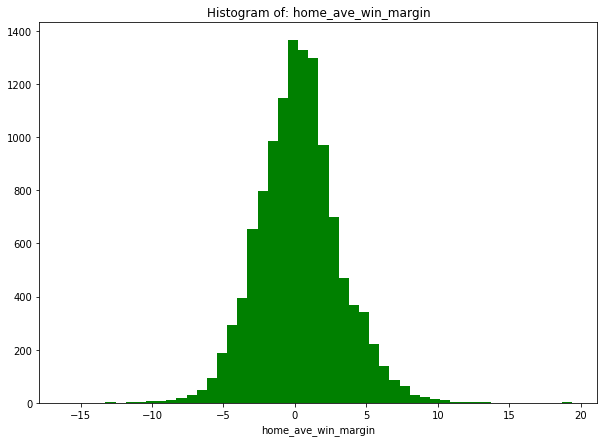

In [271]:
graph.plothist('home_ave_win_margin')

/Users/bryancombs/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


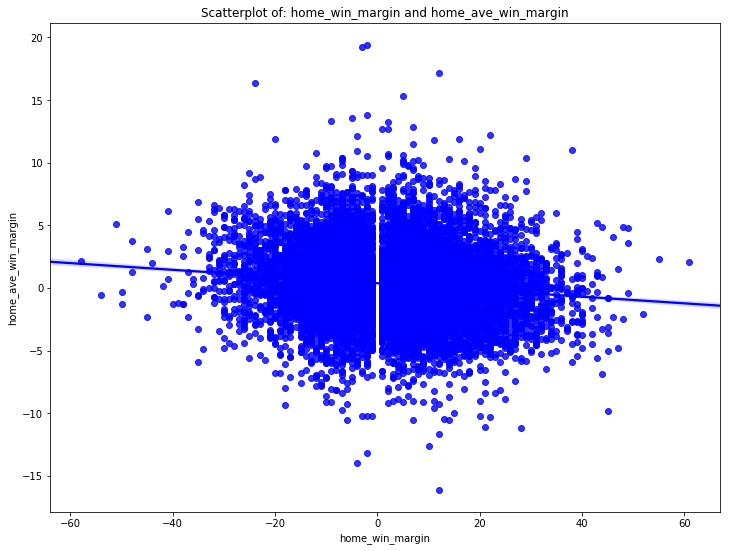

In [272]:
graph.plotscat('home_win_margin', 'home_ave_win_margin')

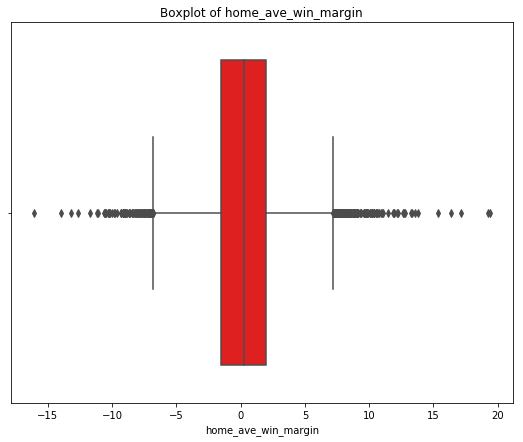

In [273]:
graph.plotbox('home_ave_win_margin')

In [274]:
nba.home_win_margin.corr(nba.home_ave_win_margin)
#strong positive correlation

-0.1235210959795386

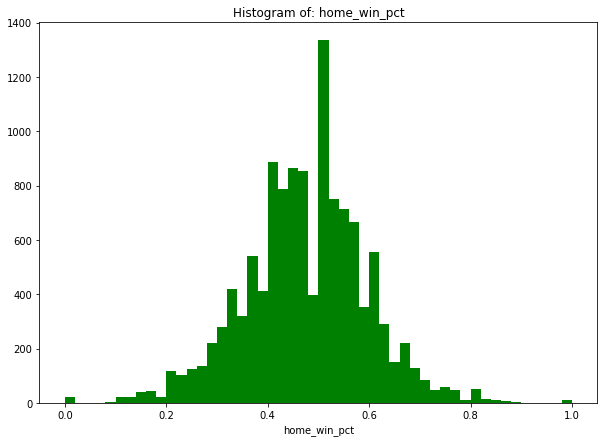

In [275]:
graph.plothist('home_win_pct')

/Users/bryancombs/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


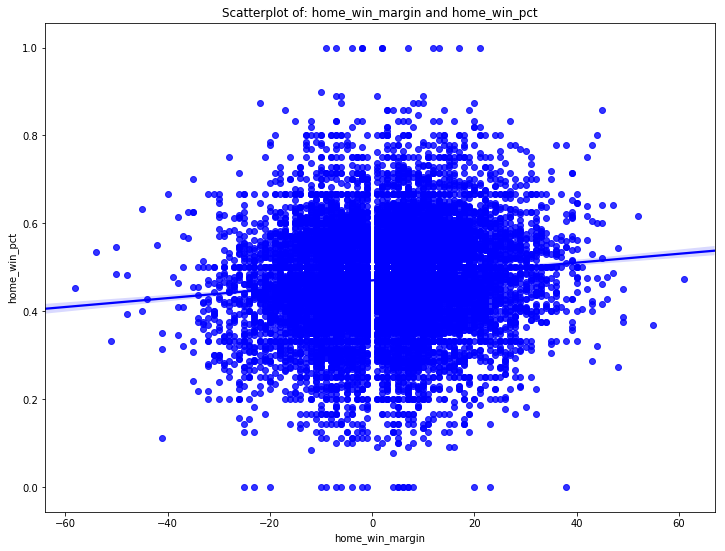

In [276]:
graph.plotscat('home_win_margin', 'home_win_pct')

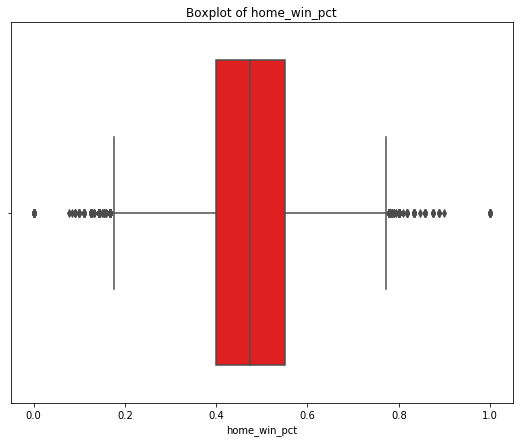

In [277]:
graph.plotbox('home_win_pct')

/Users/bryancombs/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


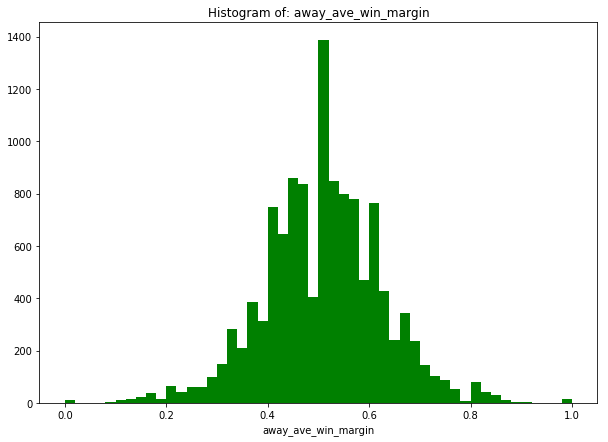

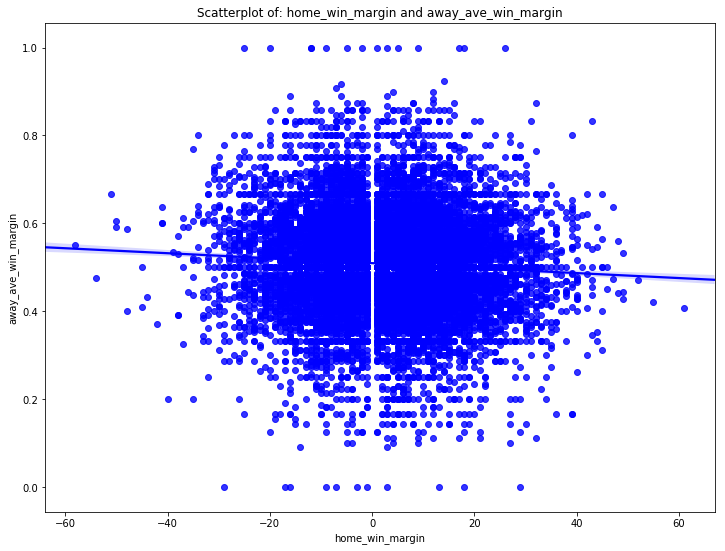

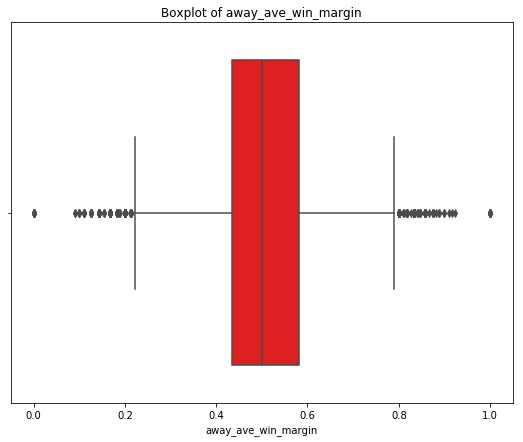

In [278]:
graph.plothist('away_ave_win_margin')
graph.plotscat('home_win_margin','away_ave_win_margin')
graph.plotbox('away_ave_win_margin')

/Users/bryancombs/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


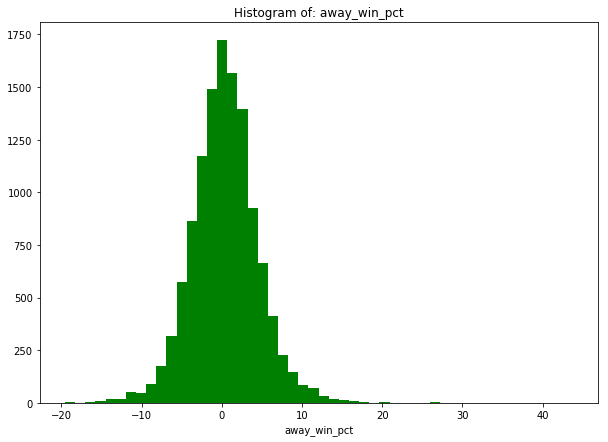

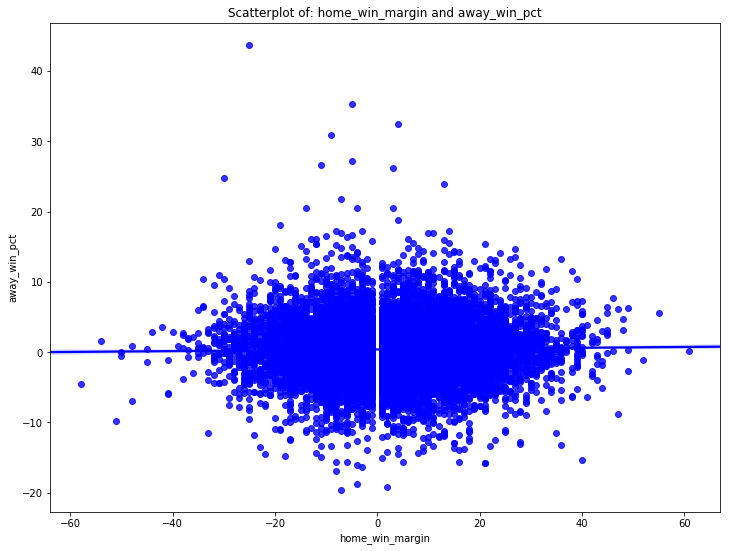

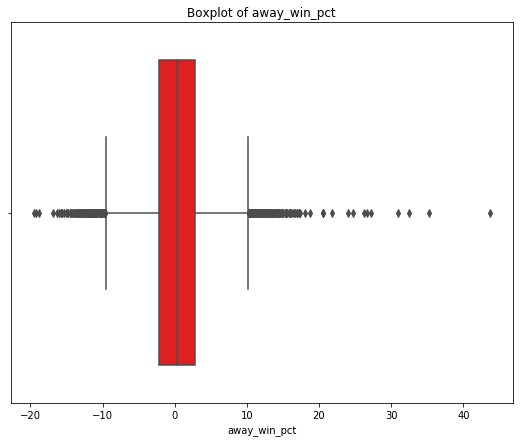

In [279]:
graph.plothist('away_win_pct')
graph.plotscat('home_win_margin','away_win_pct')
graph.plotbox('away_win_pct')

### Relative Offensive and Defensive Efficiencies

The data set has offensive and defensive efficiency data as well.
This data should be relevant in determining scores In this section I look at the efficiency numbers and create some new variables that are efficiency ratios.

/Users/bryancombs/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


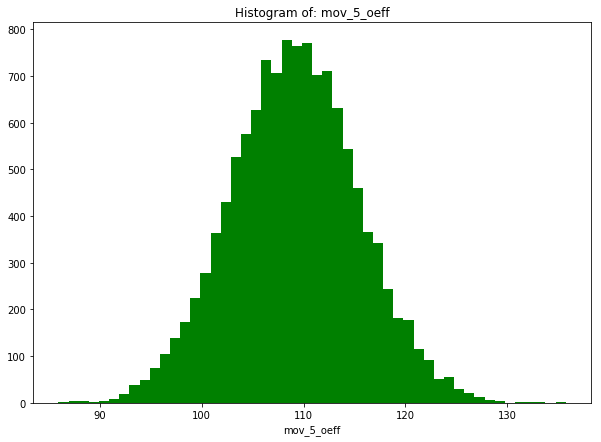

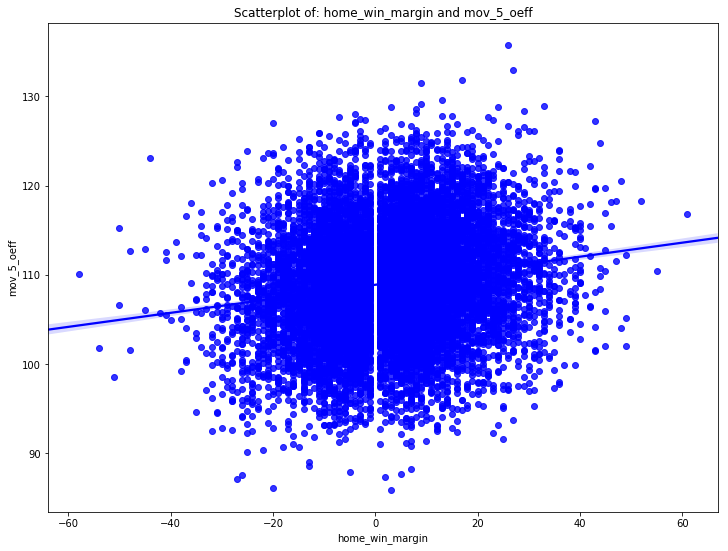

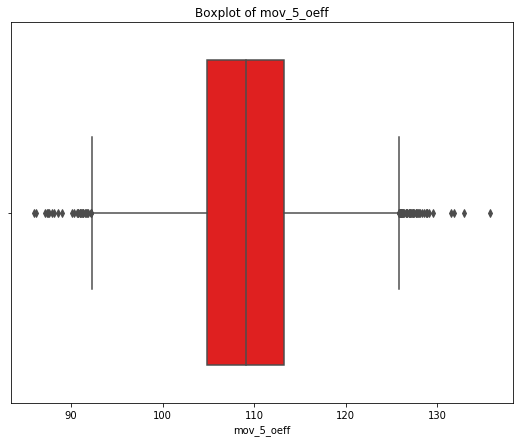

In [280]:
graph.plothist('mov_5_oeff')
graph.plotscat('home_win_margin','mov_5_oeff')
graph.plotbox('mov_5_oeff')

In [281]:
nba.home_win_margin.corr(nba.mov_5_oeff)

0.16817928245073488

/Users/bryancombs/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


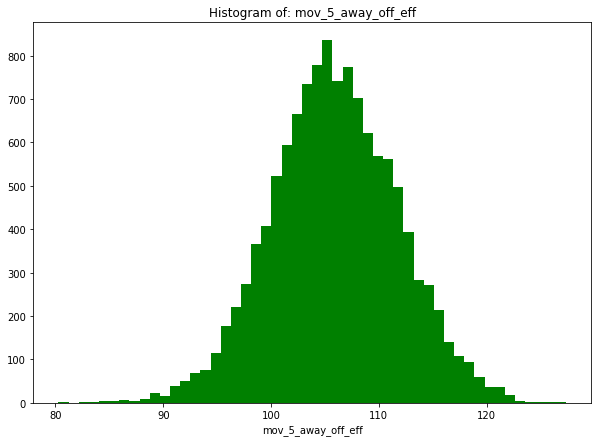

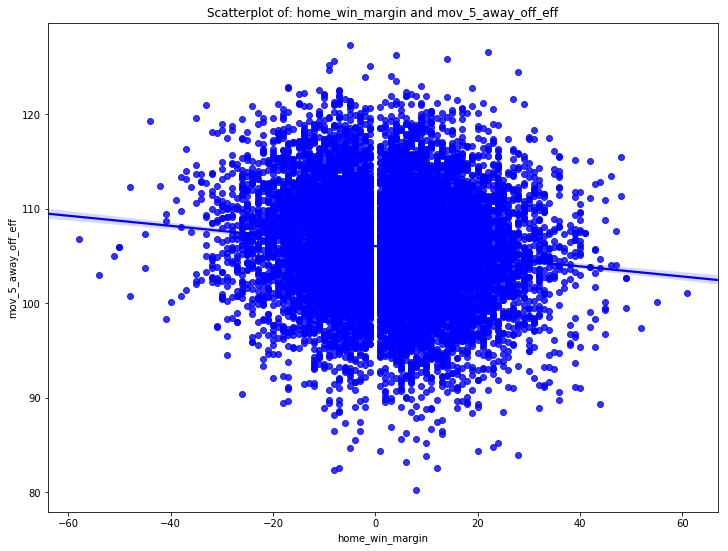

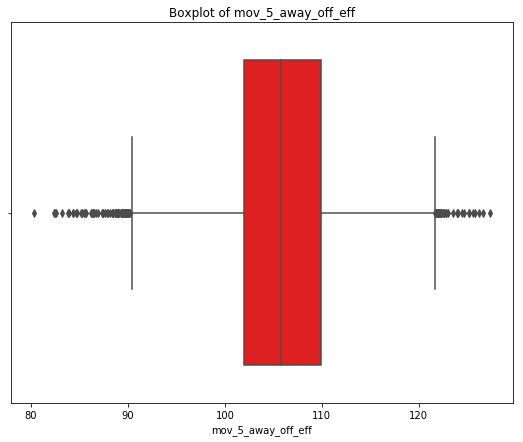

In [282]:
graph.plothist('mov_5_away_off_eff')
graph.plotscat('home_win_margin','mov_5_away_off_eff')
graph.plotbox('mov_5_away_off_eff')

In [283]:
nba.home_win_margin.corr(nba.mov_5_away_off_eff)

-0.12155448590962288

/Users/bryancombs/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


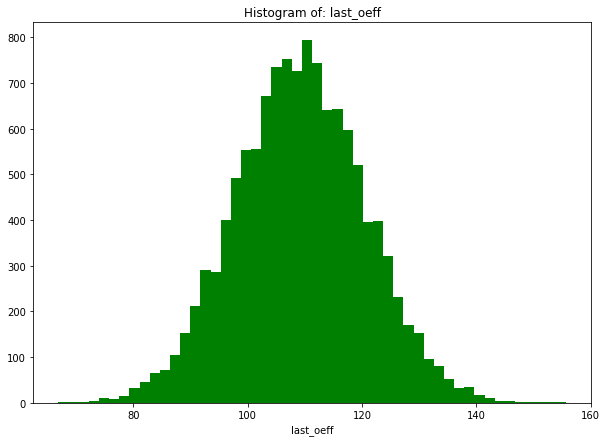

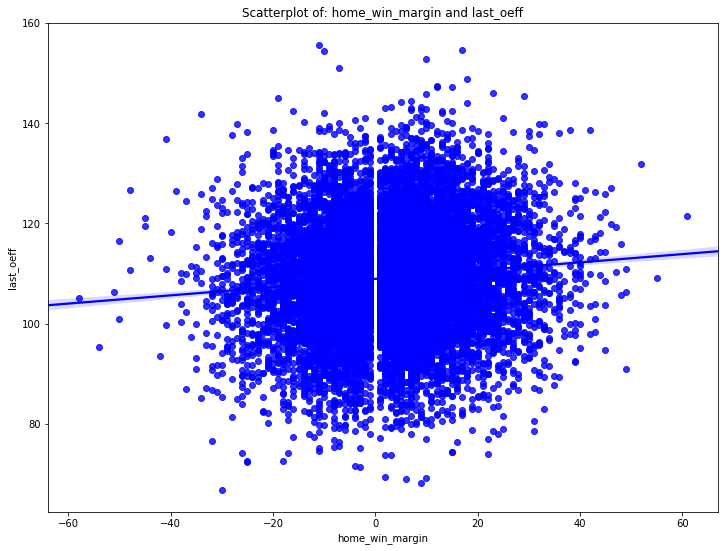

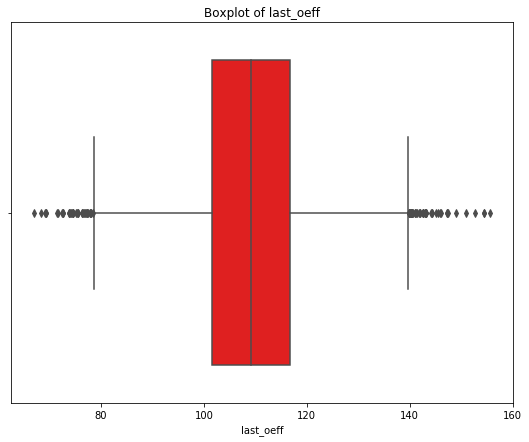

In [284]:
graph.plothist('last_oeff')
graph.plotscat('home_win_margin','last_oeff')
graph.plotbox('last_oeff')

#### Creating Features for efficiency ratios

I take the ratio of the offensive and defensive efficiencies for the home and away teams to create new features.  

In [285]:
#eff ratio ratio by line last game and 5 game moving averages
nba['eff_ratio1'] = ((nba.mov_5_deff )/(nba.mov_5_away_def_eff ))  
nba['eff_ratio2'] = (nba.mov_5_oeff/ nba.mov_5_away_off_eff) 
nba['eff_ratio3'] = ((nba.last_deff )/(nba.lastaway_def_eff ))  
nba['eff_ratio4'] = (nba.last_oeff/ nba.lastaway_off_eff)  

/Users/bryancombs/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


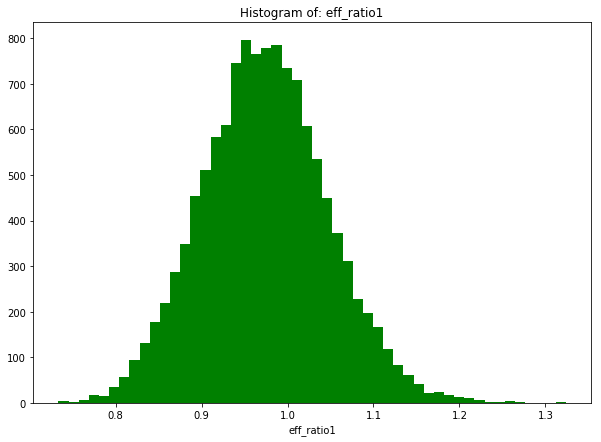

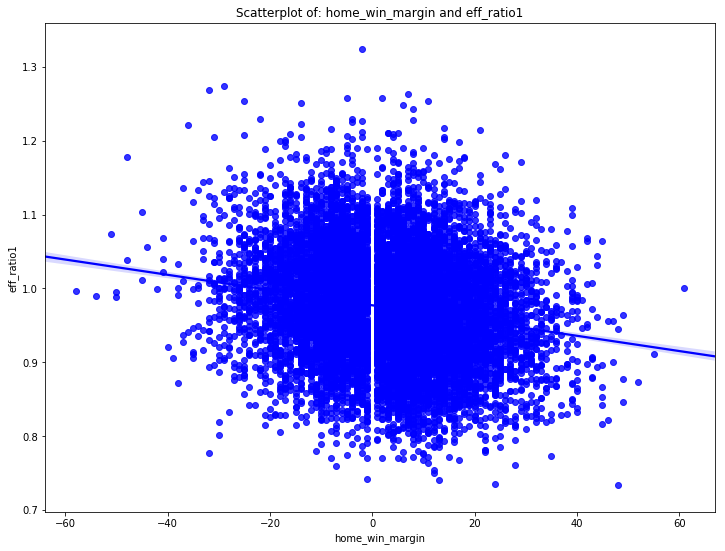

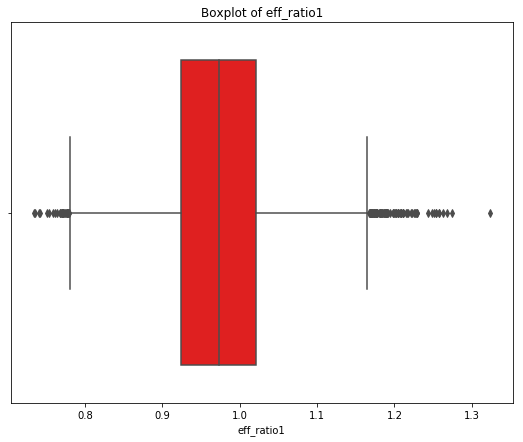

In [286]:
graph.getdata(nba)

graph.plothist('eff_ratio1')
graph.plotscat('home_win_margin','eff_ratio1')
graph.plotbox('eff_ratio1')

/Users/bryancombs/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


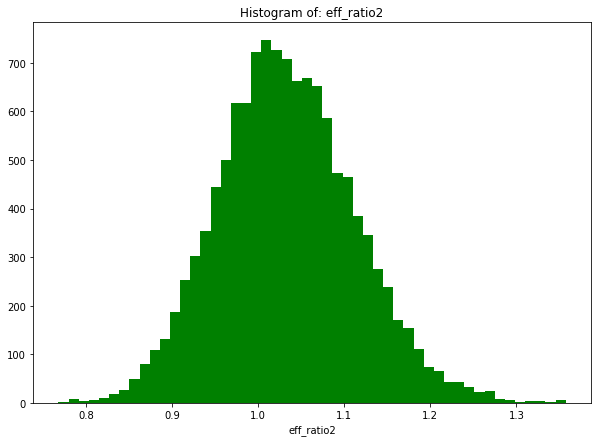

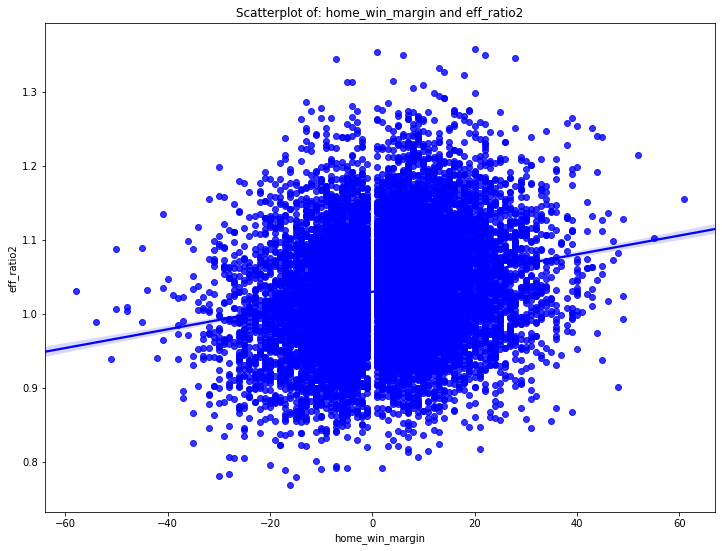

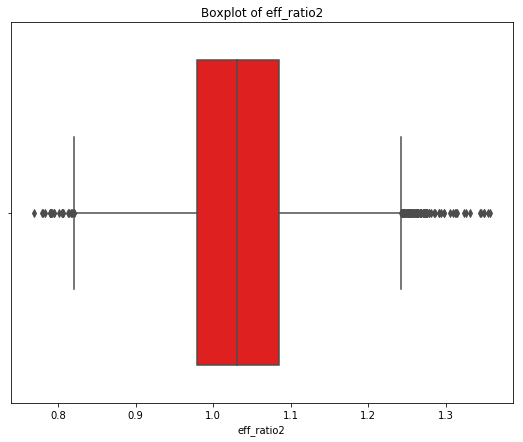

In [287]:
graph.plothist('eff_ratio2')
graph.plotscat('home_win_margin','eff_ratio2')
graph.plotbox('eff_ratio2')

/Users/bryancombs/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


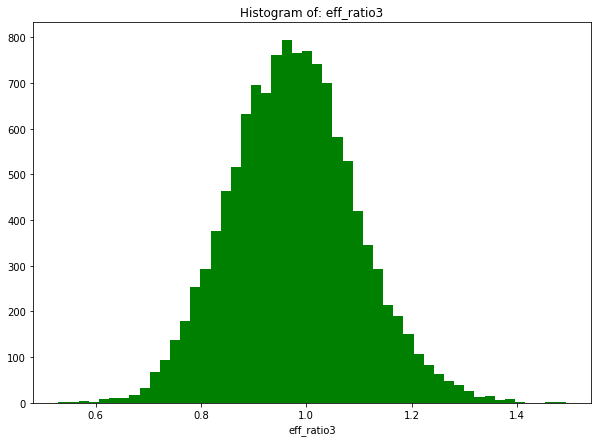

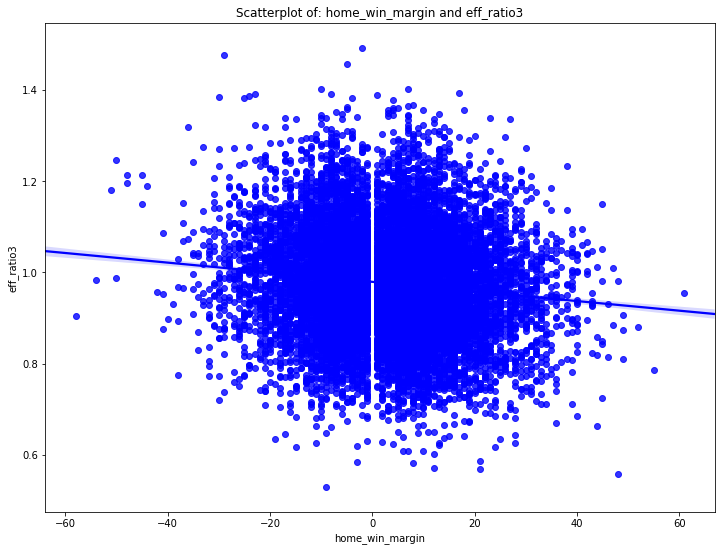

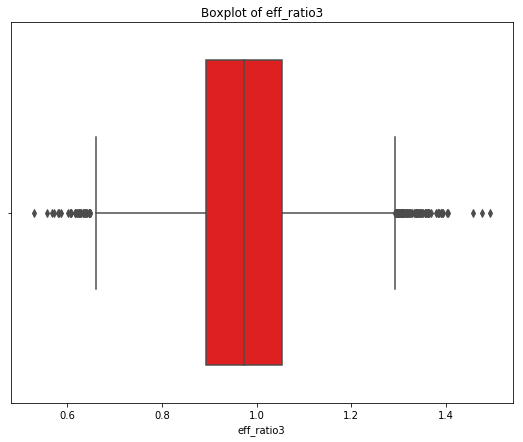

In [288]:
graph.plothist('eff_ratio3')
graph.plotscat('home_win_margin','eff_ratio3')
graph.plotbox('eff_ratio3')

/Users/bryancombs/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


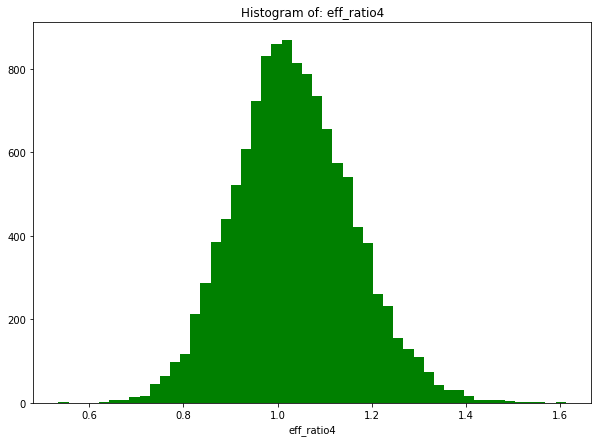

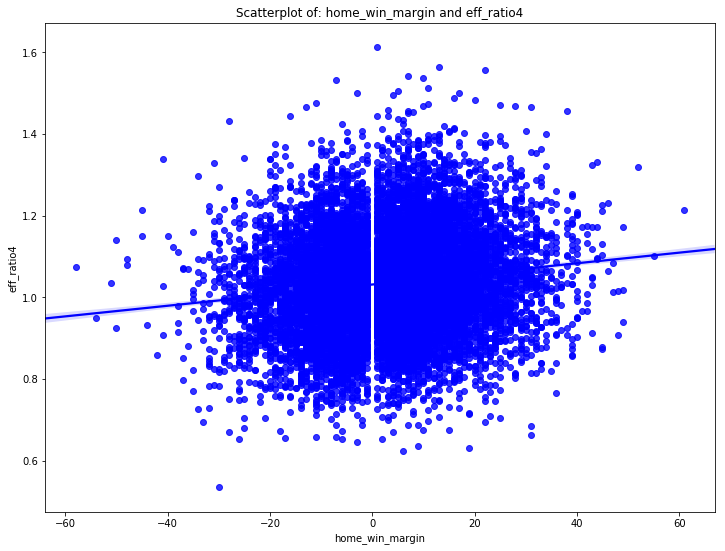

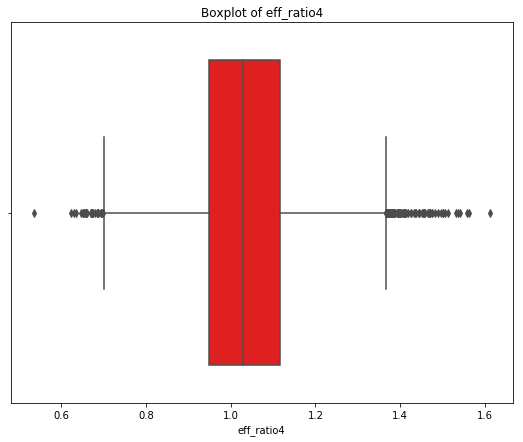

In [289]:
graph.plothist('eff_ratio4')
graph.plotscat('home_win_margin','eff_ratio4')
graph.plotbox('eff_ratio4')

### Win Margins

How much have the home and away teams been winning by lately. 

/Users/bryancombs/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


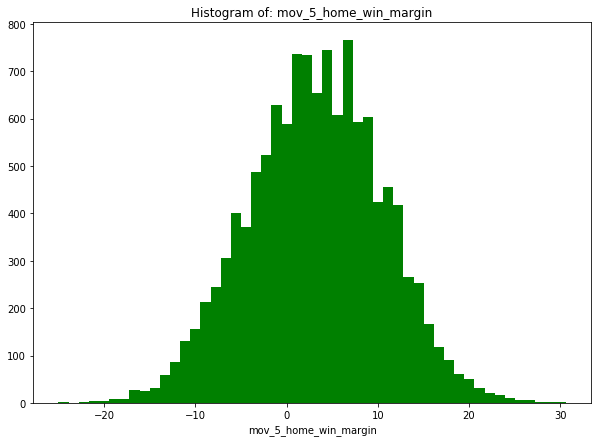

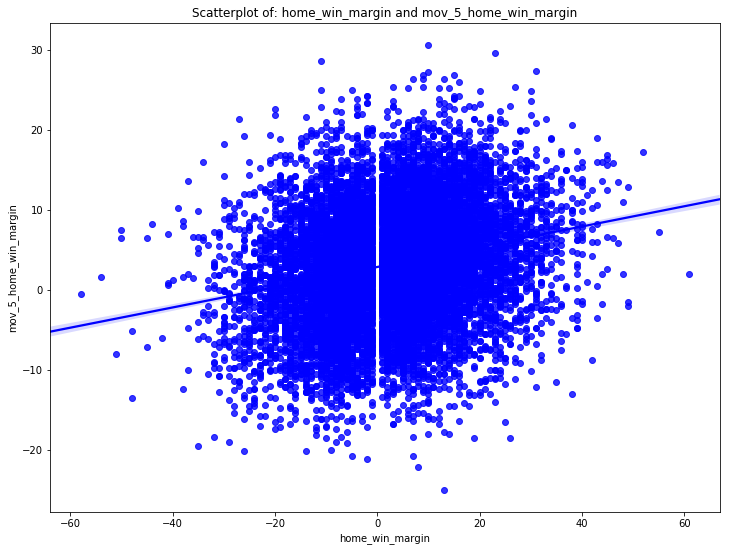

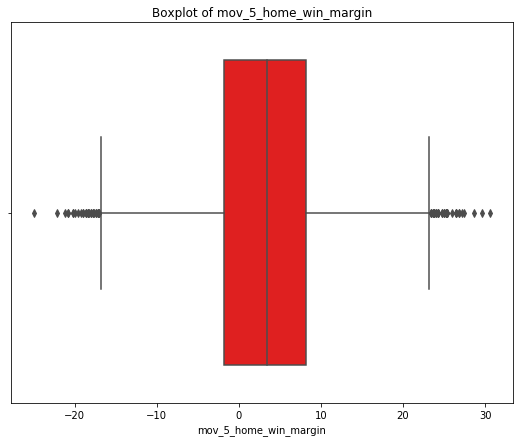

In [290]:
graph.plothist('mov_5_home_win_margin')
graph.plotscat('home_win_margin','mov_5_home_win_margin')
graph.plotbox('mov_5_home_win_margin')

/Users/bryancombs/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


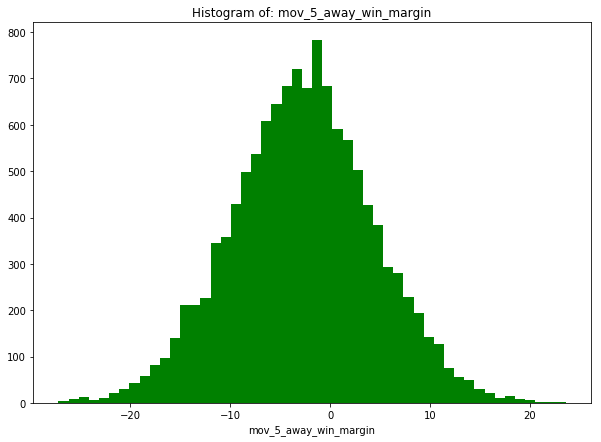

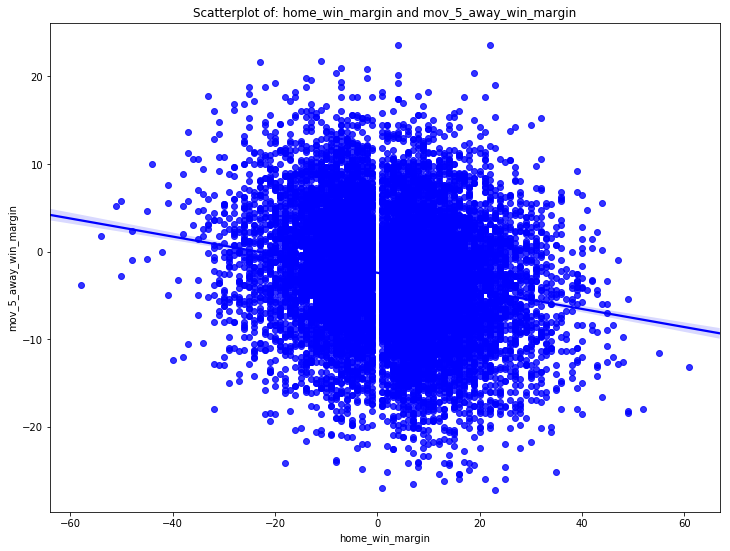

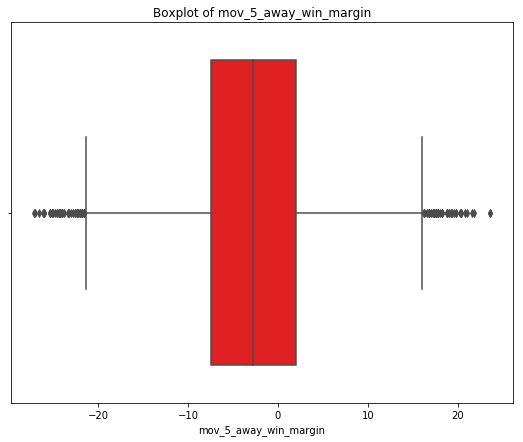

In [291]:
graph.plothist('mov_5_away_win_margin')
graph.plotscat('home_win_margin','mov_5_away_win_margin')
graph.plotbox('mov_5_away_win_margin')

/Users/bryancombs/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


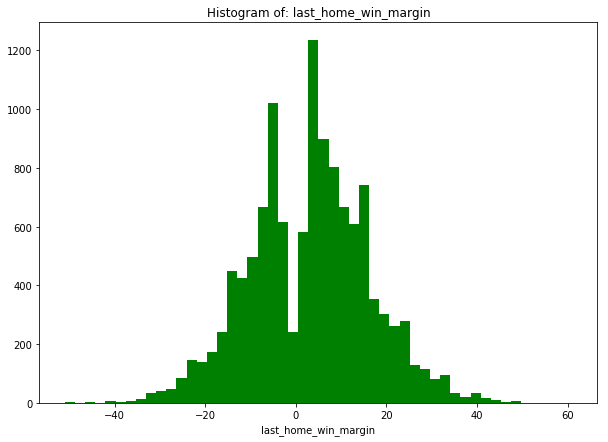

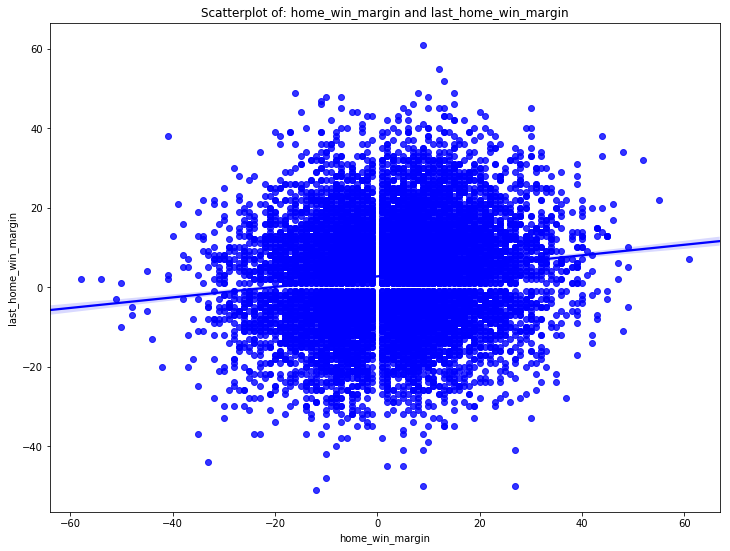

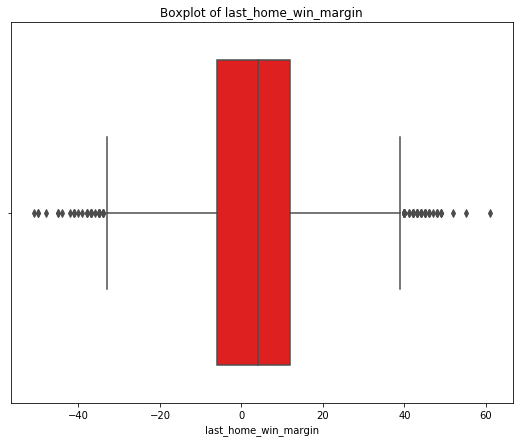

In [292]:
graph.plothist('last_home_win_margin')
graph.plotscat('home_win_margin','last_home_win_margin')
graph.plotbox('last_home_win_margin')

/Users/bryancombs/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


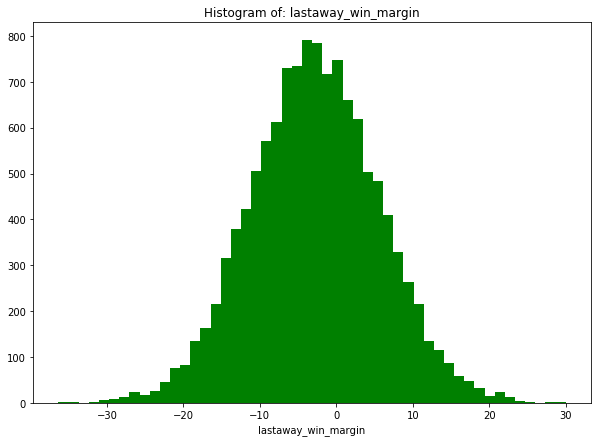

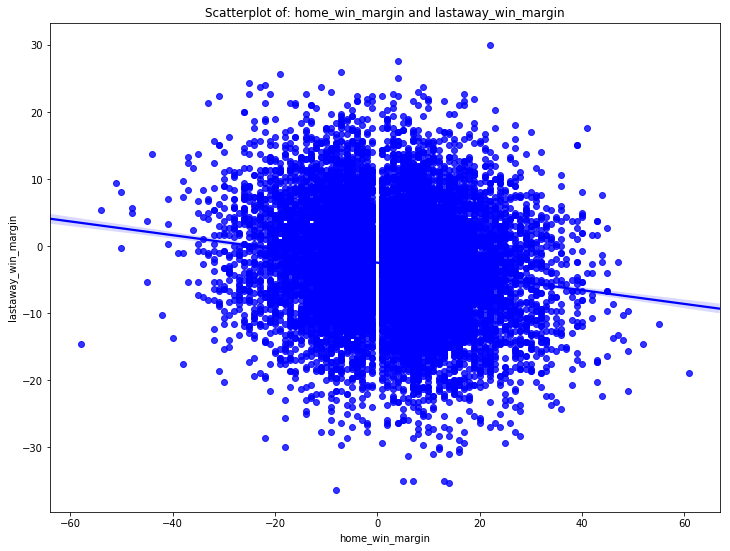

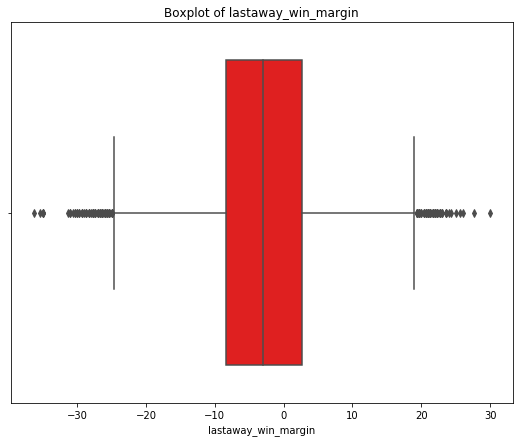

In [293]:
graph.plothist('lastaway_win_margin')
graph.plotscat('home_win_margin','lastaway_win_margin')
graph.plotbox('lastaway_win_margin')

### Game Statistics

The last category of variables are game stats, such as assists, rebounds,
free throws etc.

#### Assists

/Users/bryancombs/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


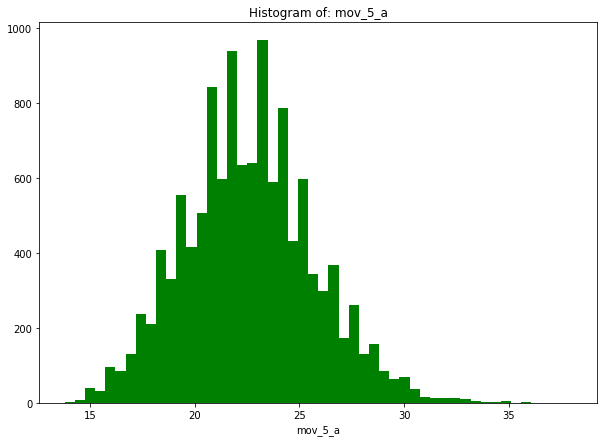

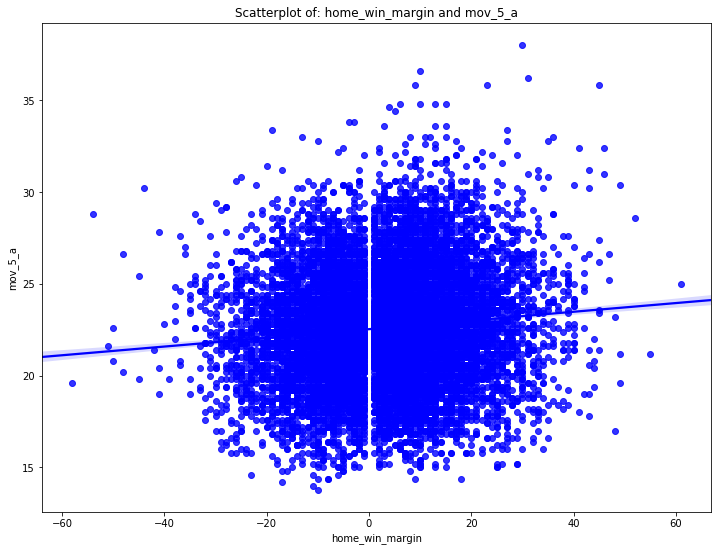

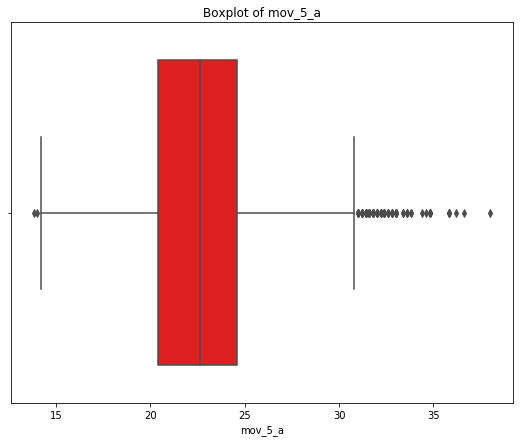

In [294]:
graph.plothist('mov_5_a')
graph.plotscat('home_win_margin','mov_5_a')
graph.plotbox('mov_5_a')

/Users/bryancombs/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


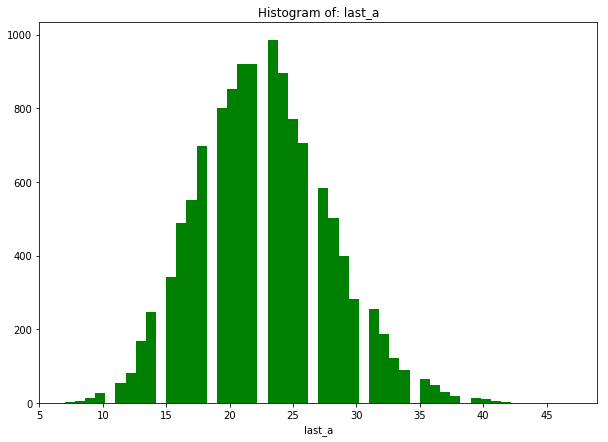

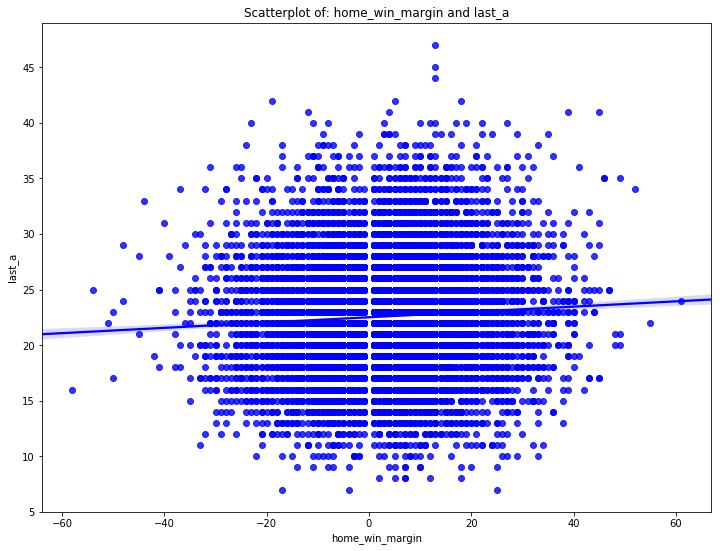

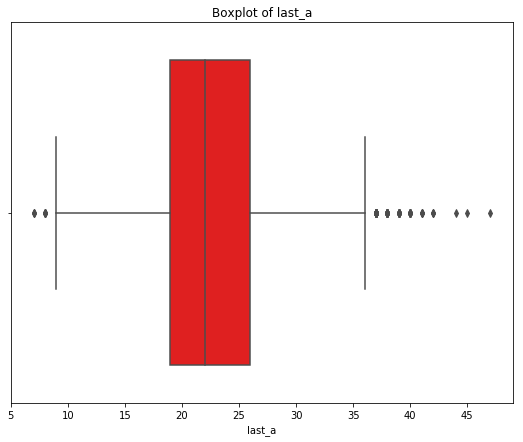

In [295]:
graph.plothist('last_a')
graph.plotscat('home_win_margin','last_a')
graph.plotbox('last_a')

/Users/bryancombs/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


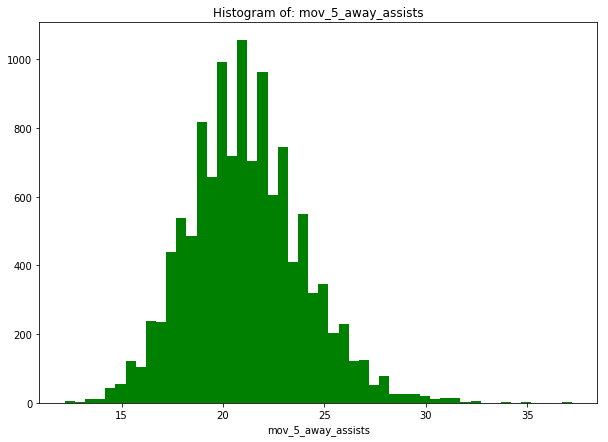

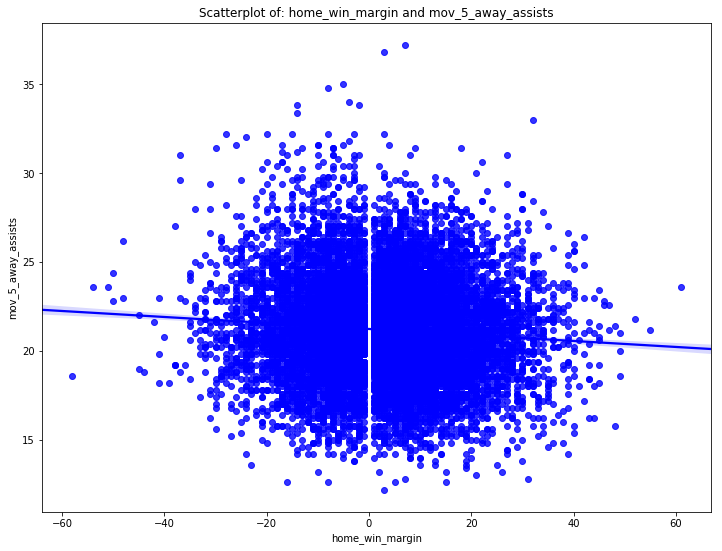

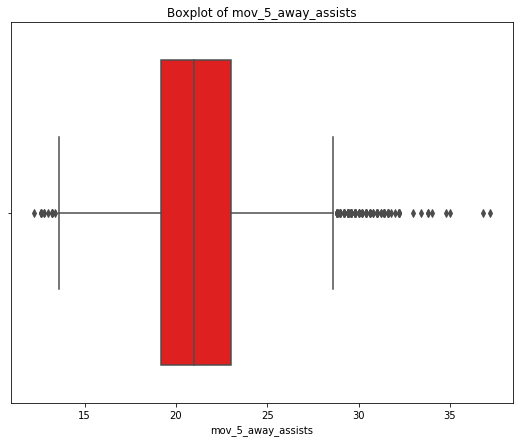

In [296]:
graph.plothist('mov_5_away_assists')
graph.plotscat('home_win_margin','mov_5_away_assists')
graph.plotbox('mov_5_away_assists')

/Users/bryancombs/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


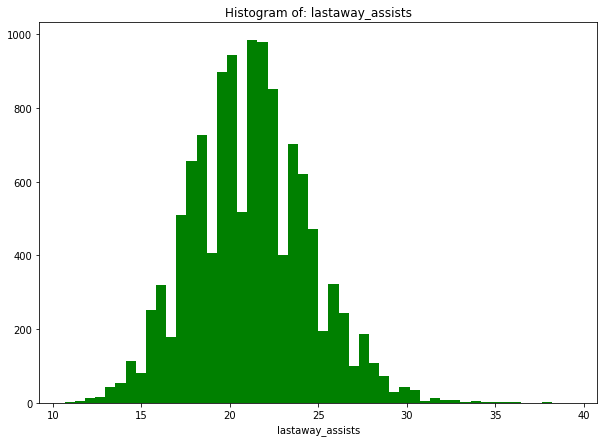

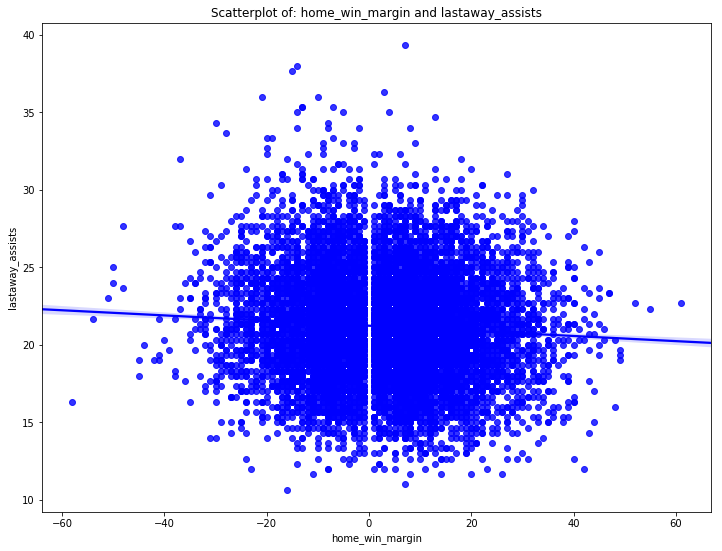

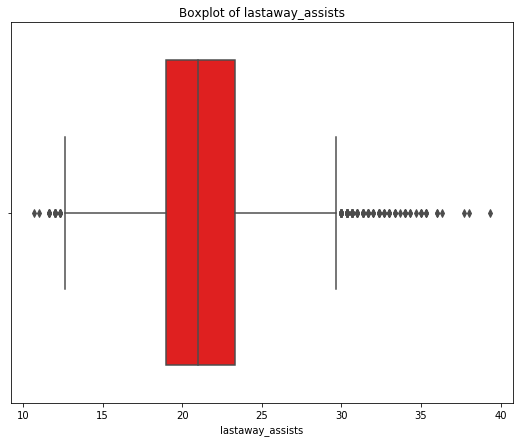

In [297]:
graph.plothist('lastaway_assists')
graph.plotscat('home_win_margin','lastaway_assists')
graph.plotbox('lastaway_assists')

#### Rebounds

/Users/bryancombs/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


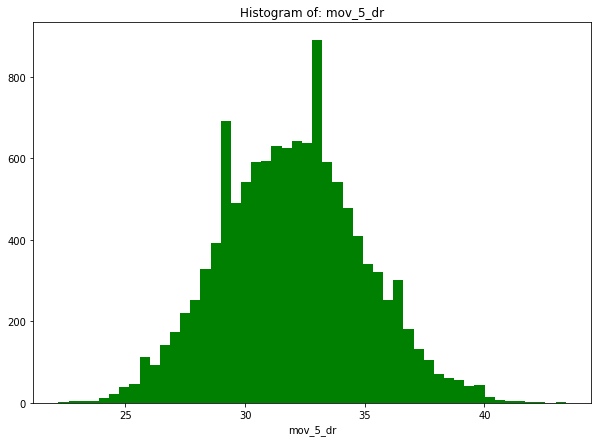

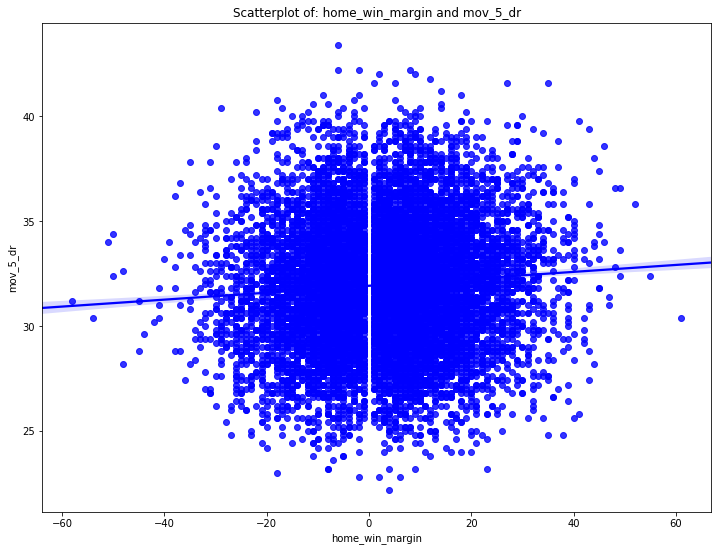

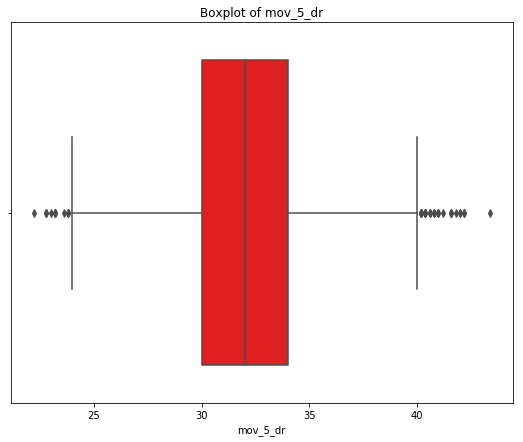

In [298]:
graph.plothist('mov_5_dr')
graph.plotscat('home_win_margin','mov_5_dr')
graph.plotbox('mov_5_dr')

/Users/bryancombs/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


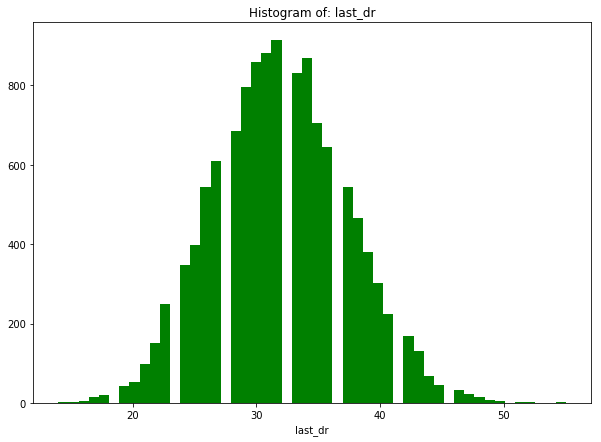

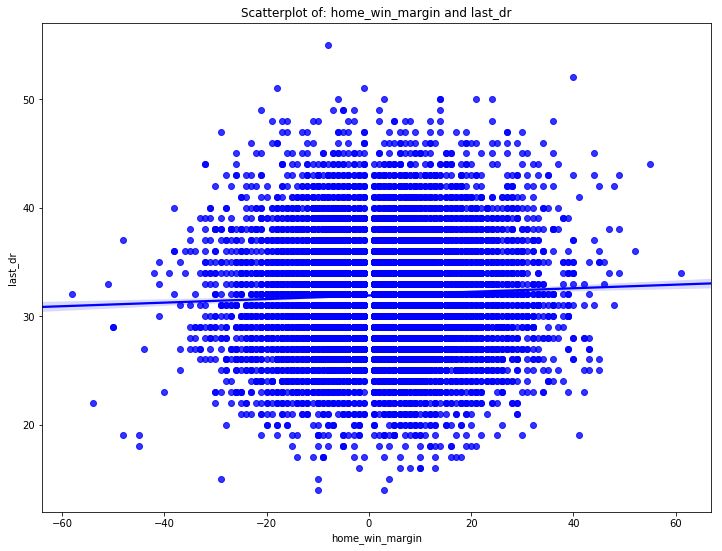

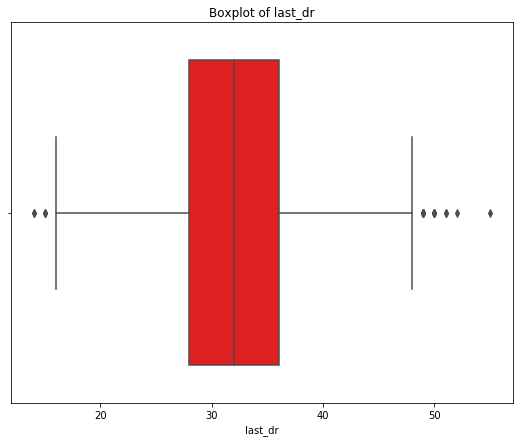

In [299]:
graph.plothist('last_dr')
graph.plotscat('home_win_margin','last_dr')
graph.plotbox('last_dr')

/Users/bryancombs/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


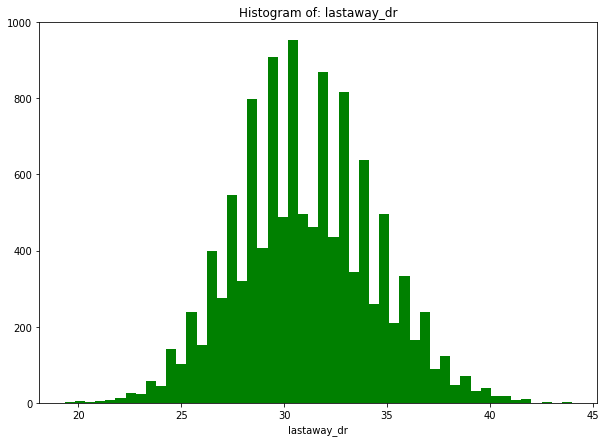

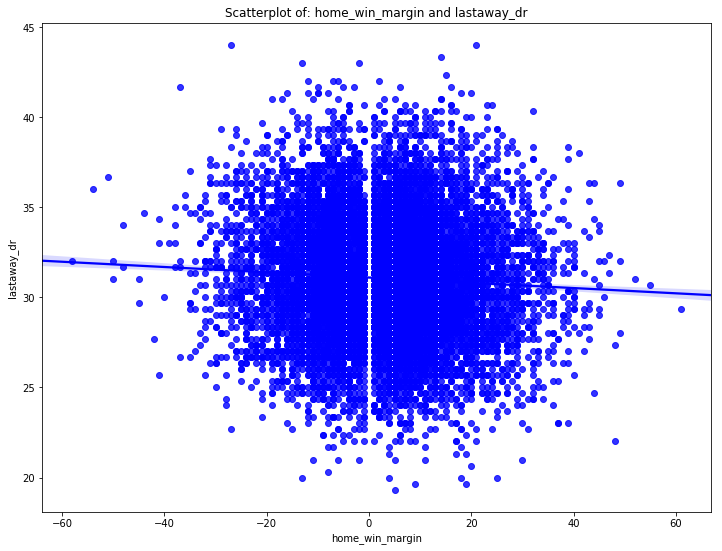

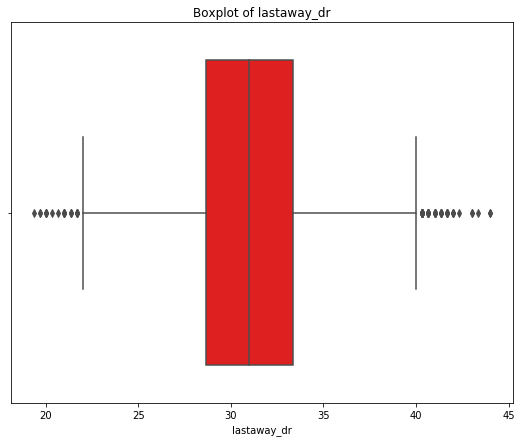

In [300]:
graph.plothist('lastaway_dr')
graph.plotscat('home_win_margin','lastaway_dr')
graph.plotbox('lastaway_dr')

In [301]:
nba.mov_5_or

5        13.4
7        11.4
8        12.4
9        13.6
10       11.4
11       13.8
12       14.4
13       12.0
14       12.2
15       12.4
16       11.4
17       10.2
18        8.4
19        9.8
20       11.8
21       12.8
22        9.2
23       12.2
24        8.6
25       18.6
26       16.0
27        9.6
28       10.4
30       10.0
31       11.0
32       13.8
33        9.4
34       11.0
35       11.8
37       13.0
         ... 
14077     7.6
14078     8.4
14079    14.6
14080    12.8
14081     5.6
14082     8.6
14083    10.8
14084     9.8
14085     7.8
14086     6.4
14087    10.8
14088    10.6
14089     6.4
14090     7.8
14091    10.4
14092    12.0
14093     6.2
14094     9.2
14095     8.4
14096    12.4
14097     9.4
14098    11.0
14099    12.8
14100    11.4
14101     8.0
14102     8.0
14103    12.2
14104     9.8
14105     8.2
14106     8.2
Name: mov_5_or, Length: 12145, dtype: float64

/Users/bryancombs/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


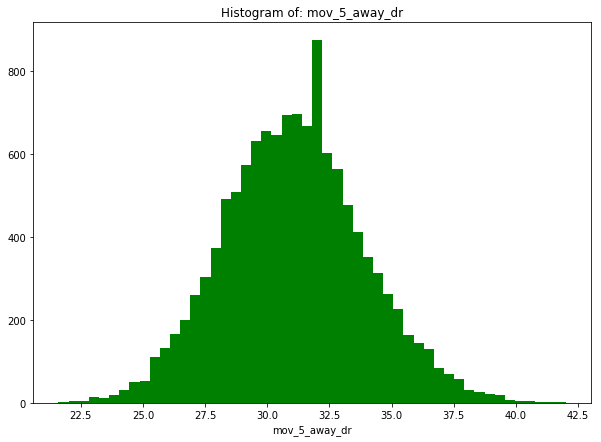

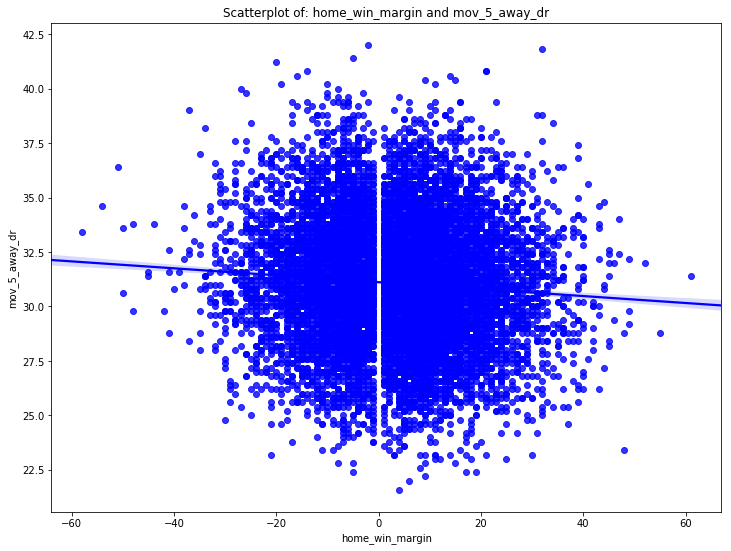

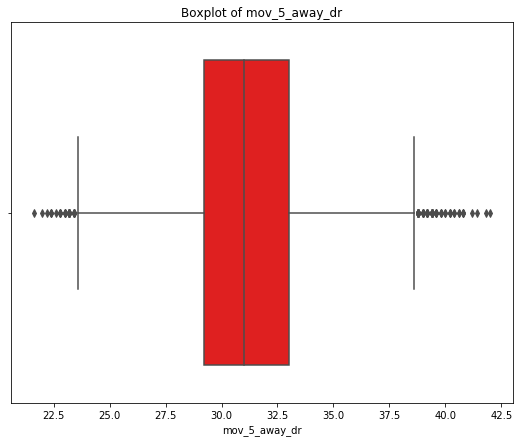

In [303]:
graph.plothist('mov_5_away_dr')
graph.plotscat('home_win_margin','mov_5_away_dr')
graph.plotbox('mov_5_away_dr')


/Users/bryancombs/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


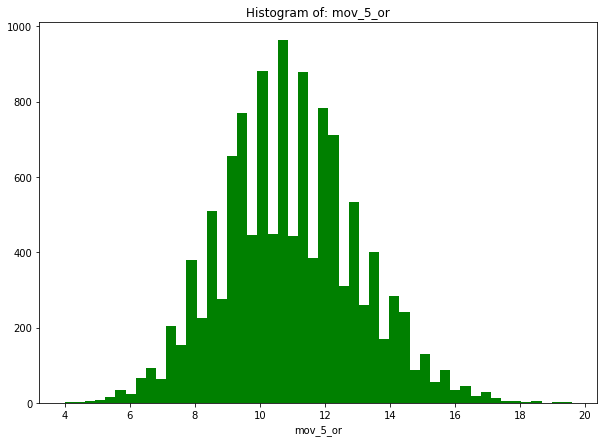

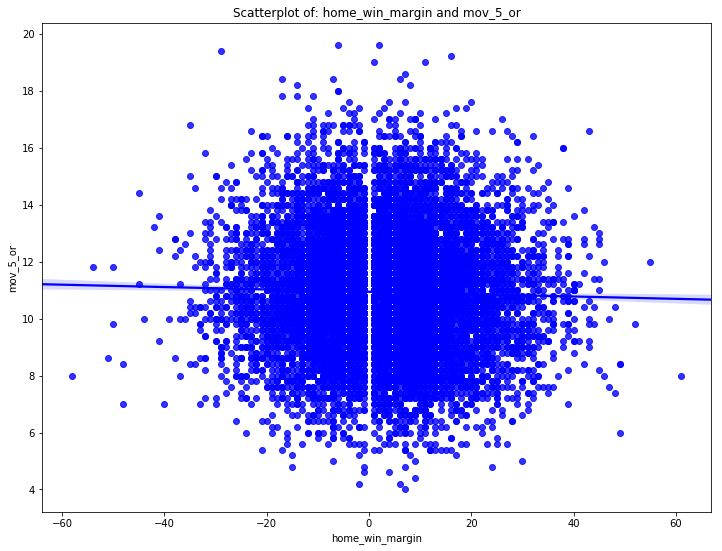

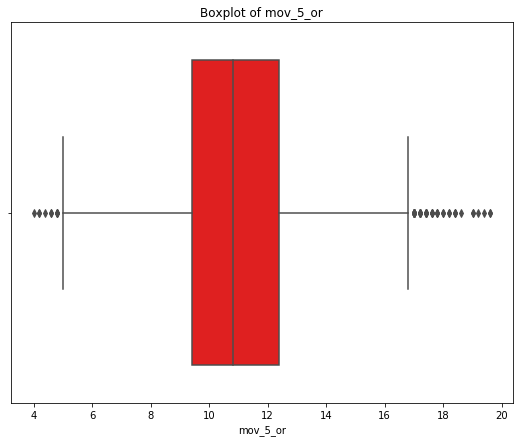

In [304]:
graph.plothist('mov_5_or')
graph.plotscat('home_win_margin','mov_5_or')
graph.plotbox('mov_5_or')

/Users/bryancombs/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


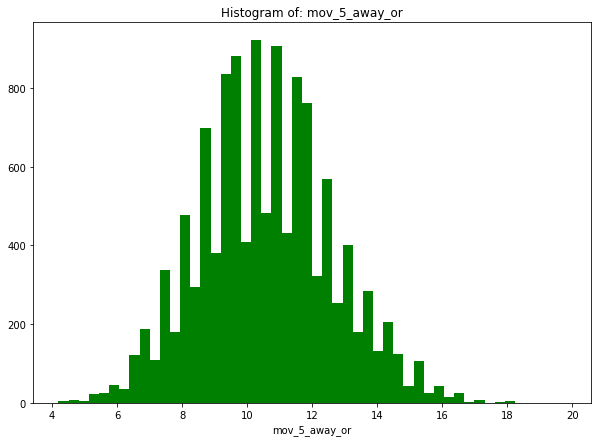

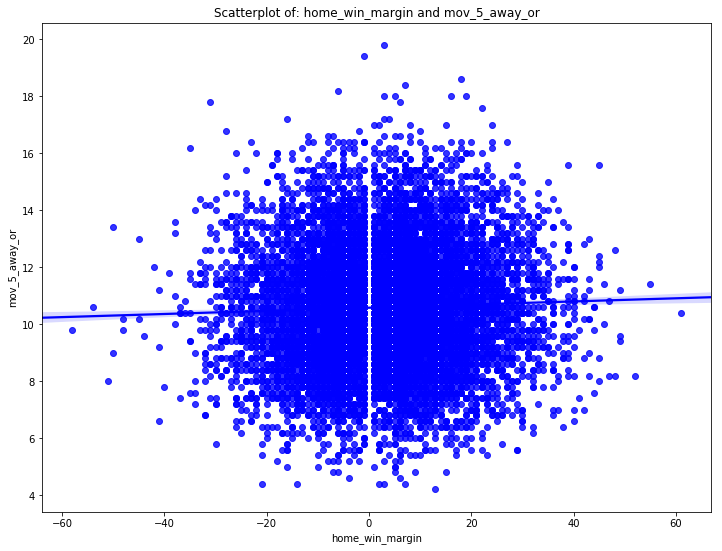

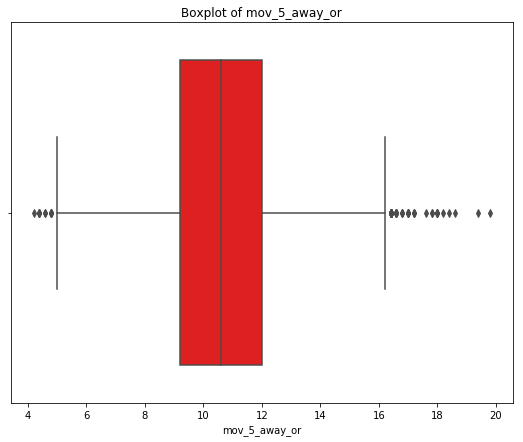

In [305]:
graph.plothist('mov_5_away_or')
graph.plotscat('home_win_margin','mov_5_away_or')
graph.plotbox('mov_5_away_or')

/Users/bryancombs/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


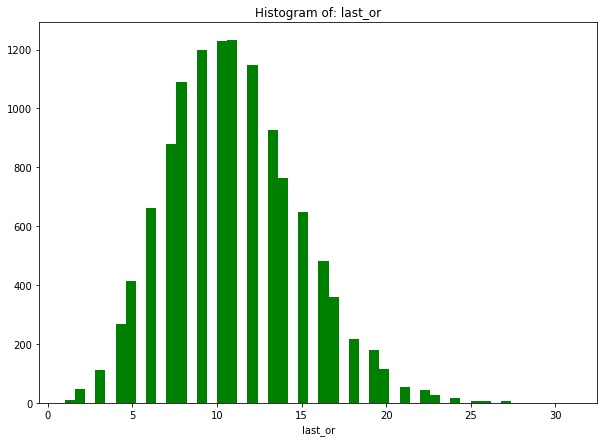

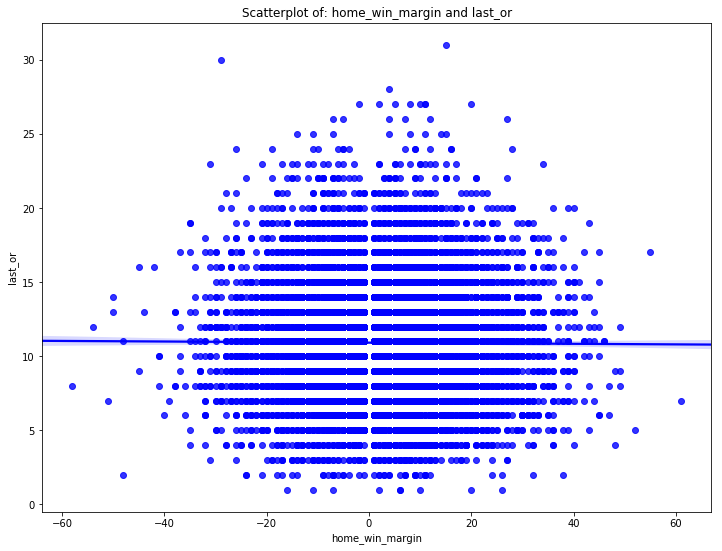

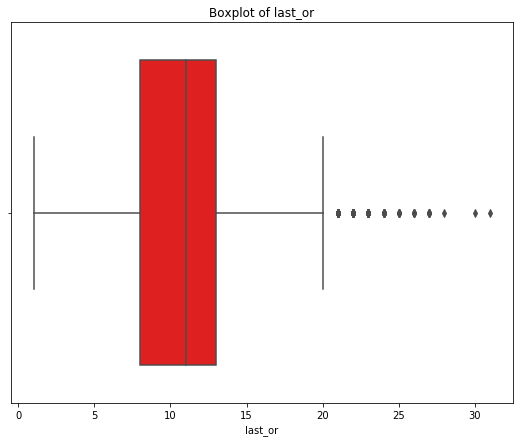

In [306]:
graph.plothist('last_or')
graph.plotscat('home_win_margin','last_or')
graph.plotbox('last_or')

/Users/bryancombs/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


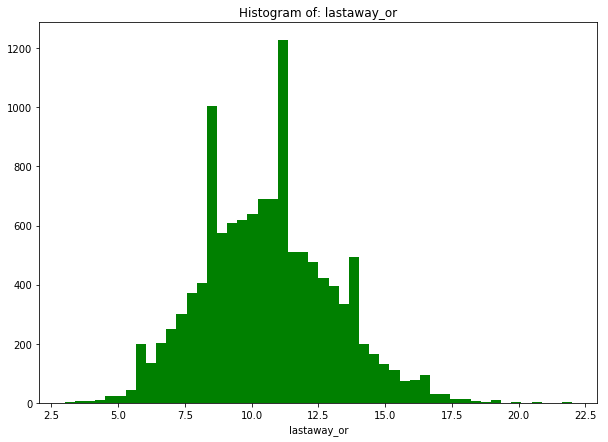

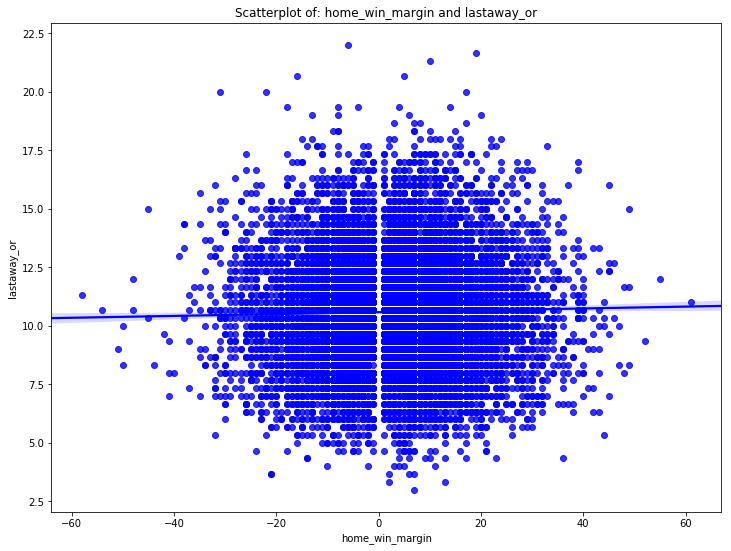

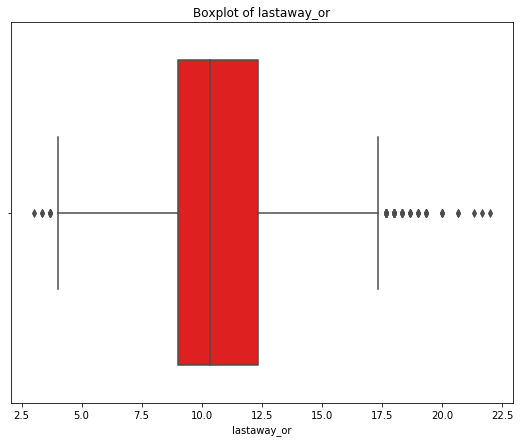

In [307]:
graph.plothist('lastaway_or')
graph.plotscat('home_win_margin','lastaway_or')
graph.plotbox('lastaway_or')

#### Shooting Variables

/Users/bryancombs/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


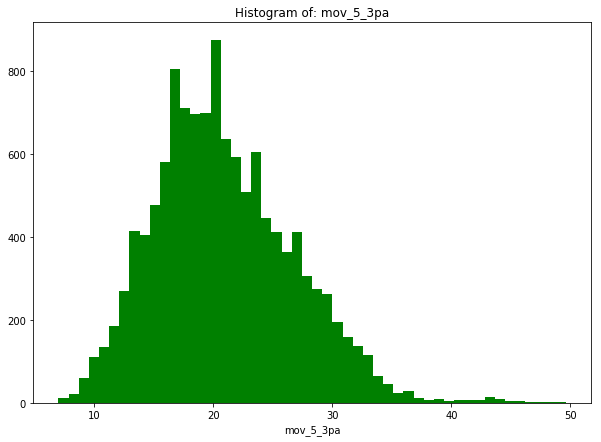

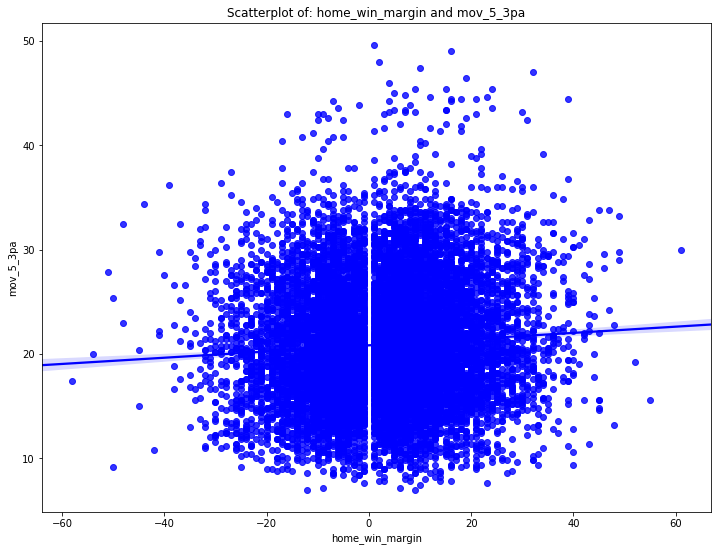

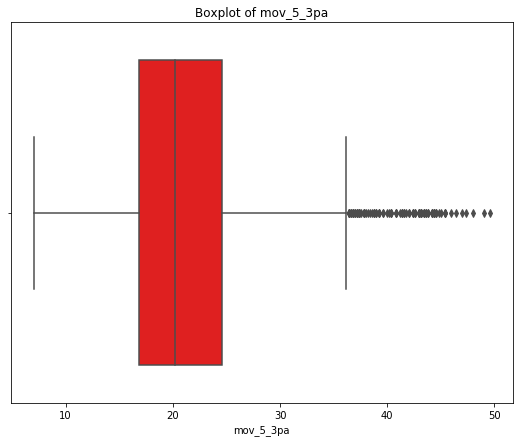

In [308]:
graph.plothist('mov_5_3pa')
graph.plotscat('home_win_margin','mov_5_3pa')
graph.plotbox('mov_5_3pa')

/Users/bryancombs/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


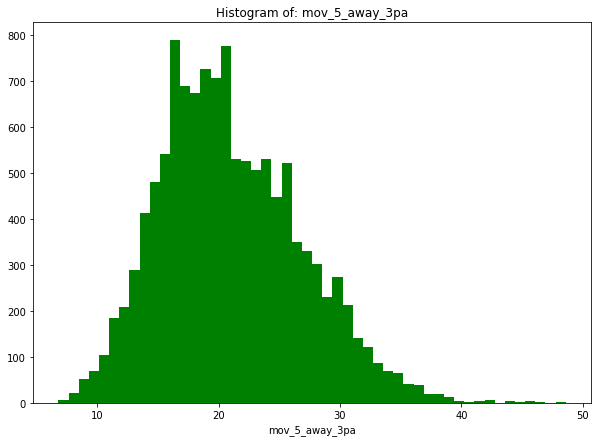

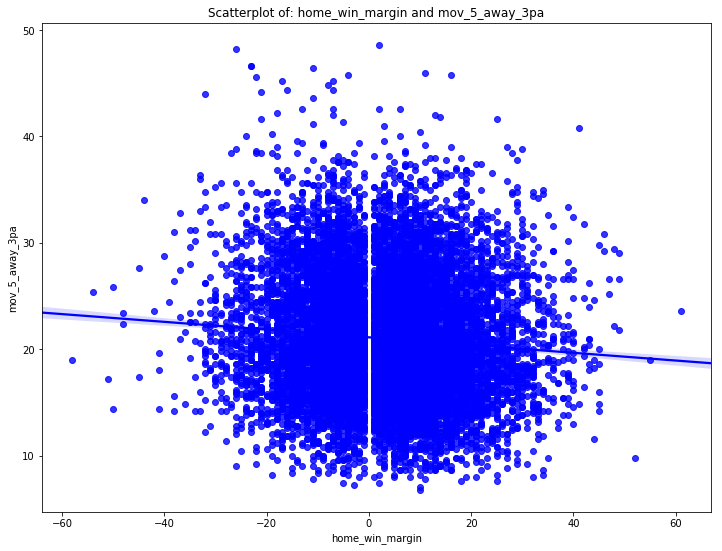

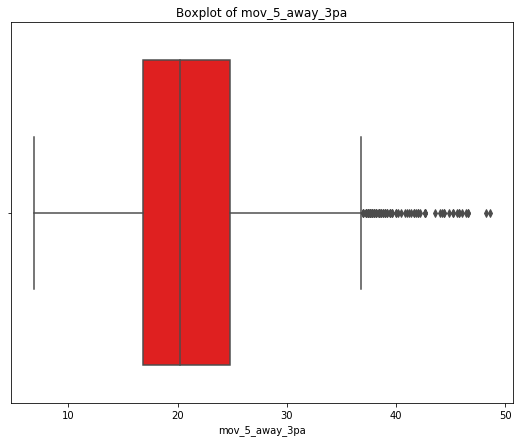

In [309]:
graph.plothist('mov_5_away_3pa')
graph.plotscat('home_win_margin','mov_5_away_3pa')
graph.plotbox('mov_5_away_3pa')

/Users/bryancombs/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


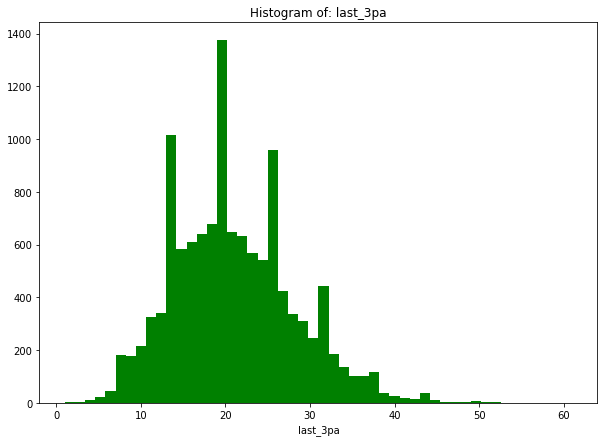

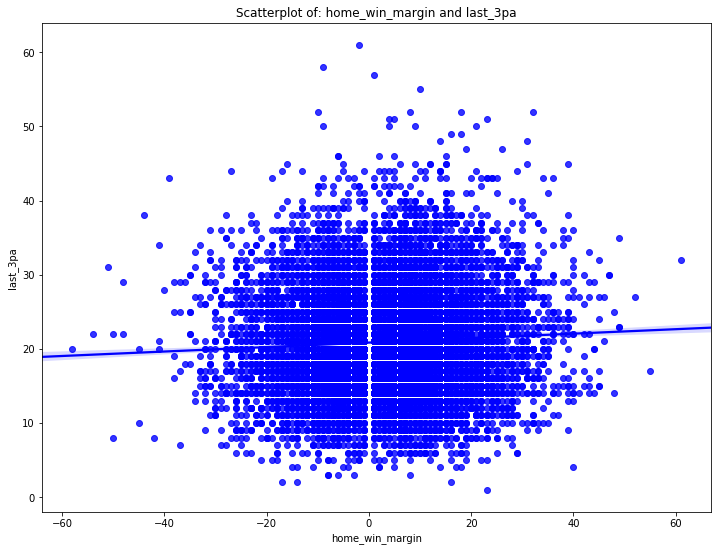

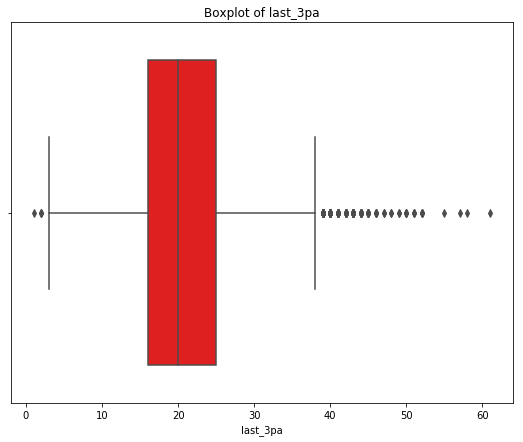

In [310]:
graph.plothist('last_3pa')
graph.plotscat('home_win_margin','last_3pa')
graph.plotbox('last_3pa')

/Users/bryancombs/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


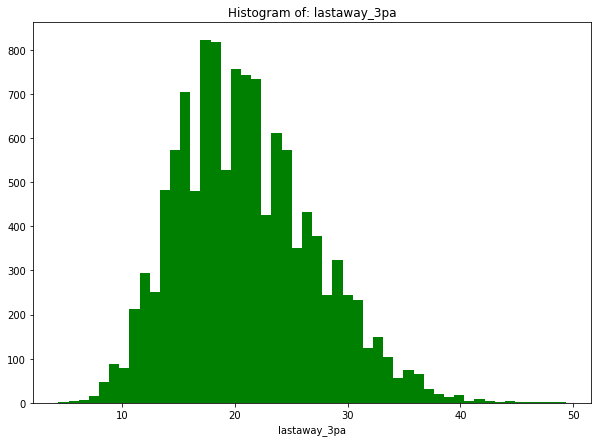

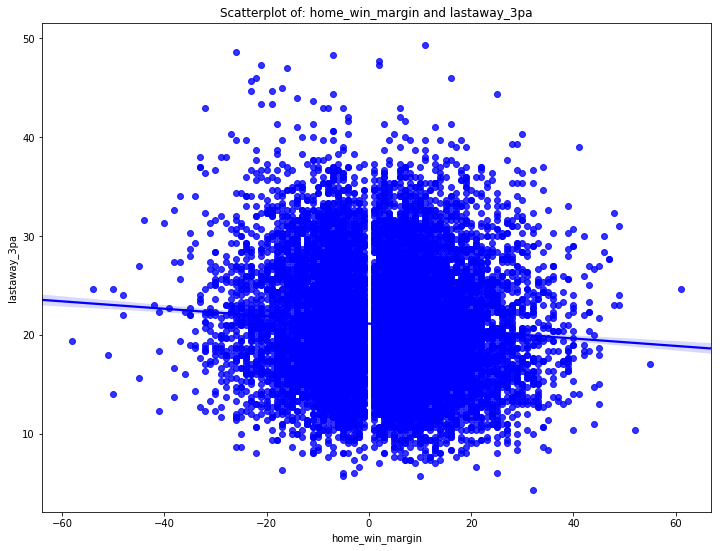

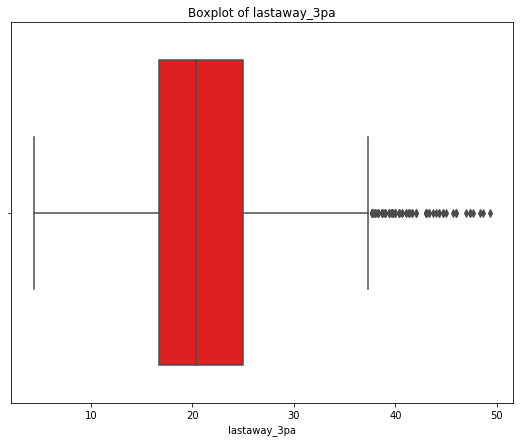

In [311]:
graph.plothist('lastaway_3pa')
graph.plotscat('home_win_margin','lastaway_3pa')
graph.plotbox('lastaway_3pa')

/Users/bryancombs/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


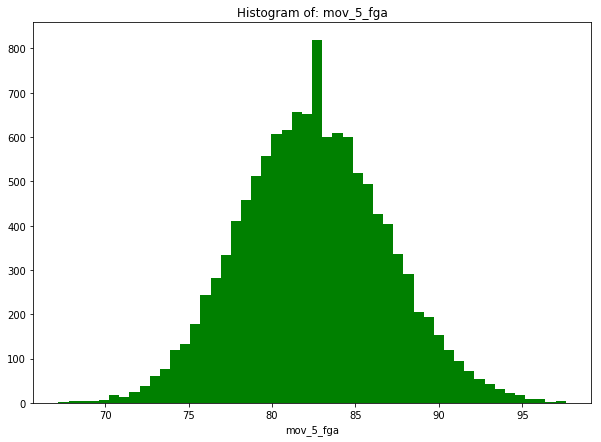

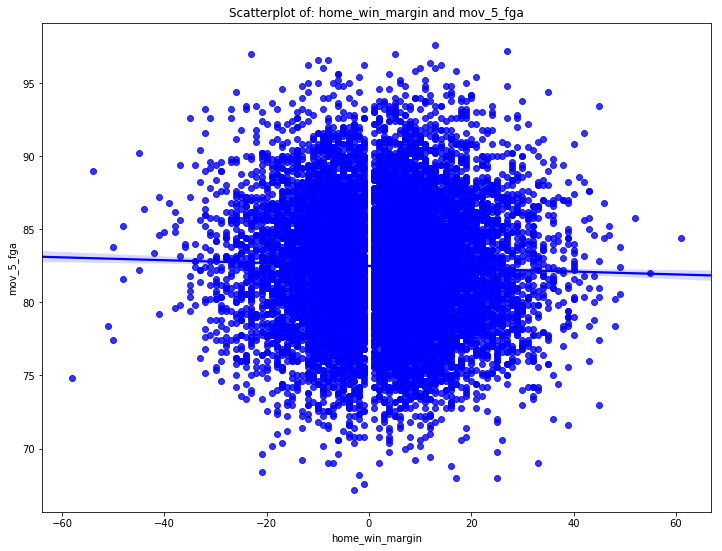

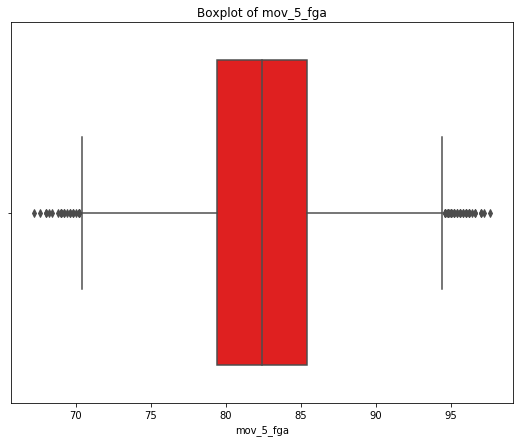

In [312]:
graph.plothist('mov_5_fga')
graph.plotscat('home_win_margin','mov_5_fga')
graph.plotbox('mov_5_fga')

/Users/bryancombs/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


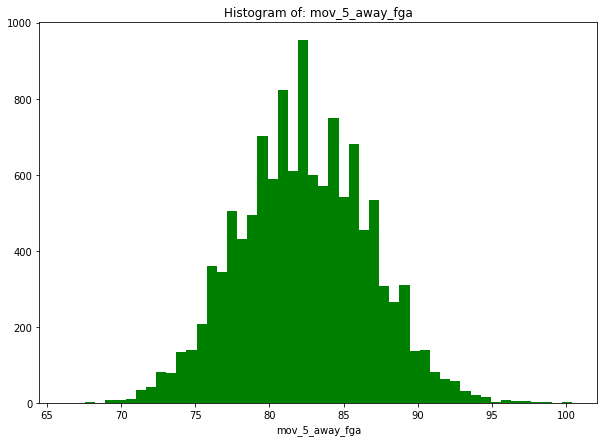

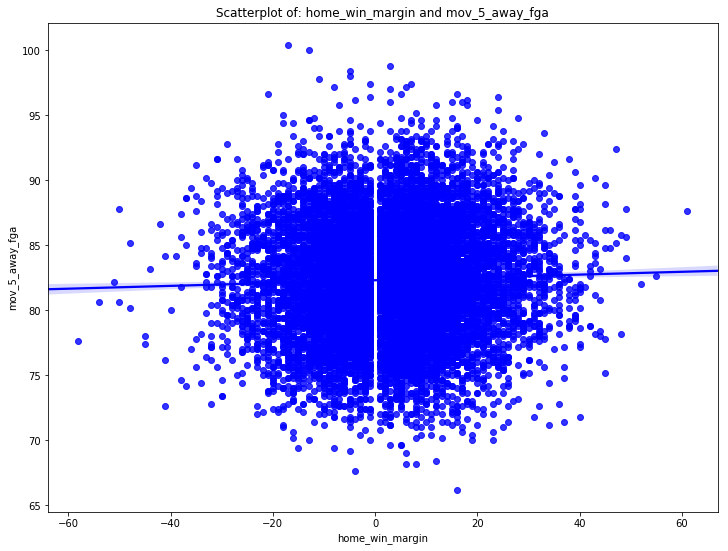

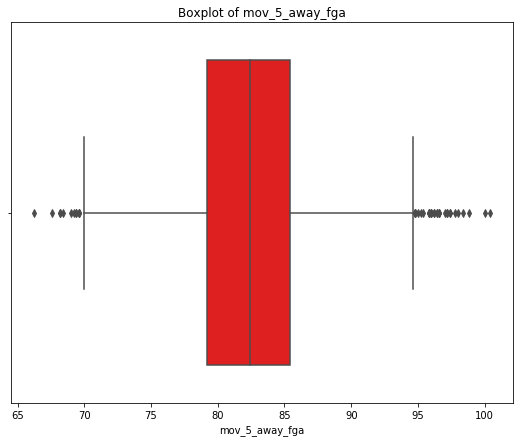

In [313]:
graph.plothist('mov_5_away_fga')
graph.plotscat('home_win_margin','mov_5_away_fga')
graph.plotbox('mov_5_away_fga')

/Users/bryancombs/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


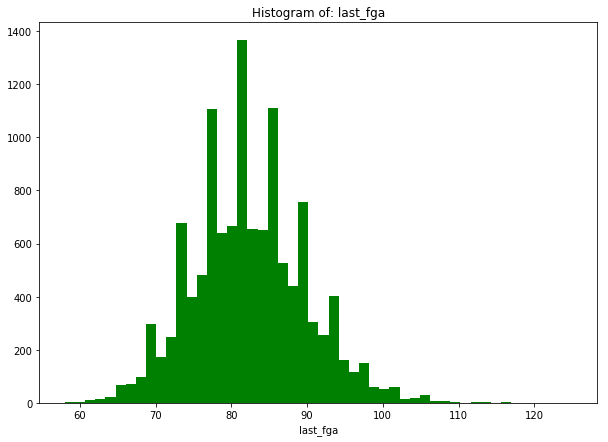

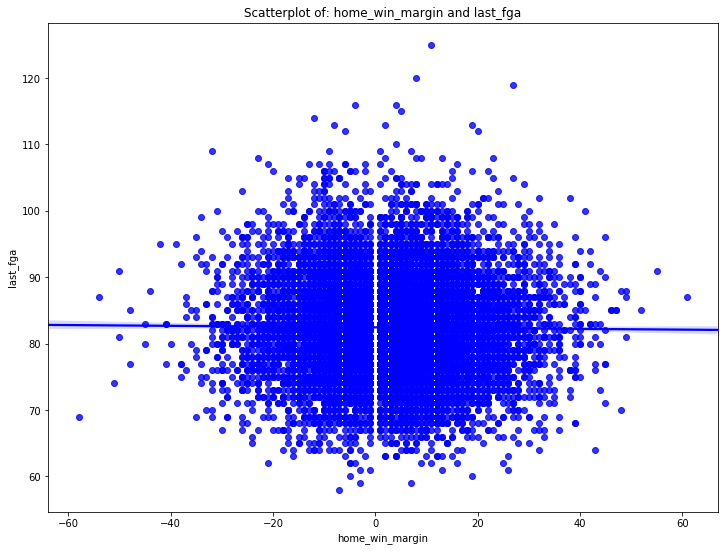

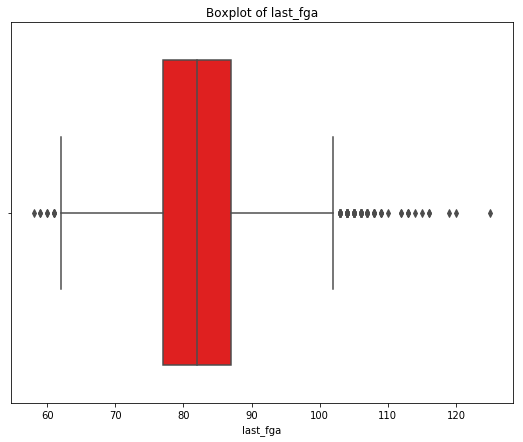

In [314]:
graph.plothist('last_fga')
graph.plotscat('home_win_margin','last_fga')
graph.plotbox('last_fga')

/Users/bryancombs/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


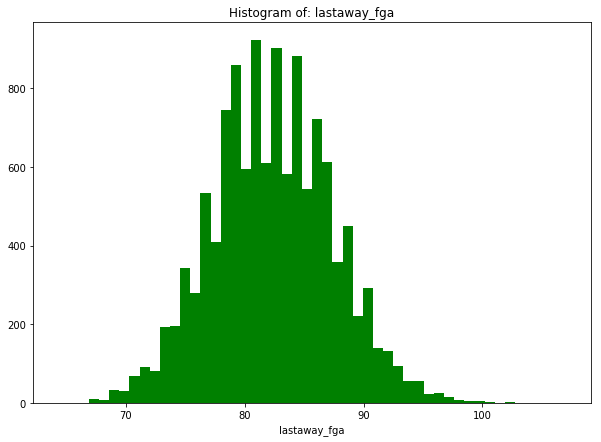

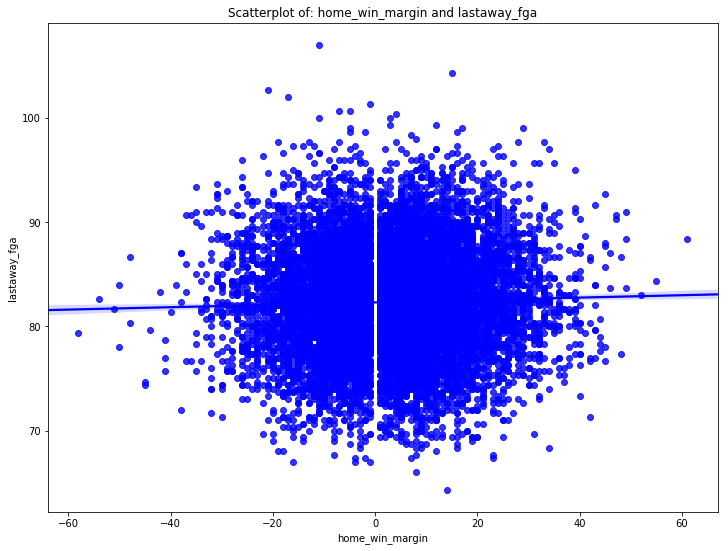

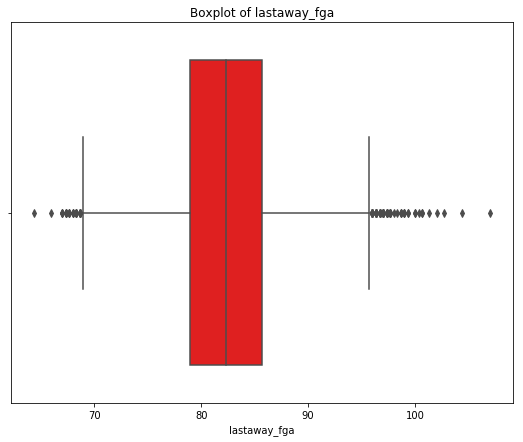

In [315]:
graph.plothist('lastaway_fga')
graph.plotscat('home_win_margin','lastaway_fga')
graph.plotbox('lastaway_fga')

/Users/bryancombs/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


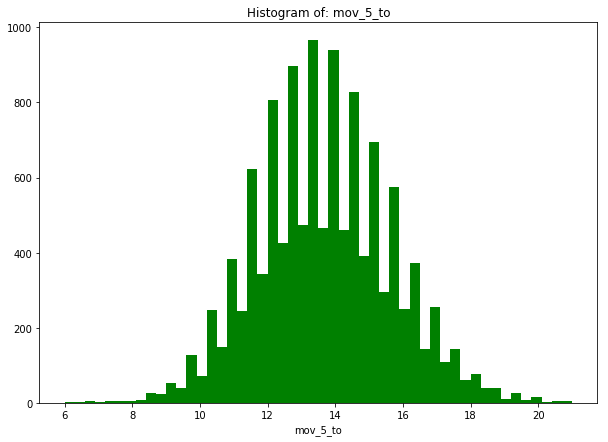

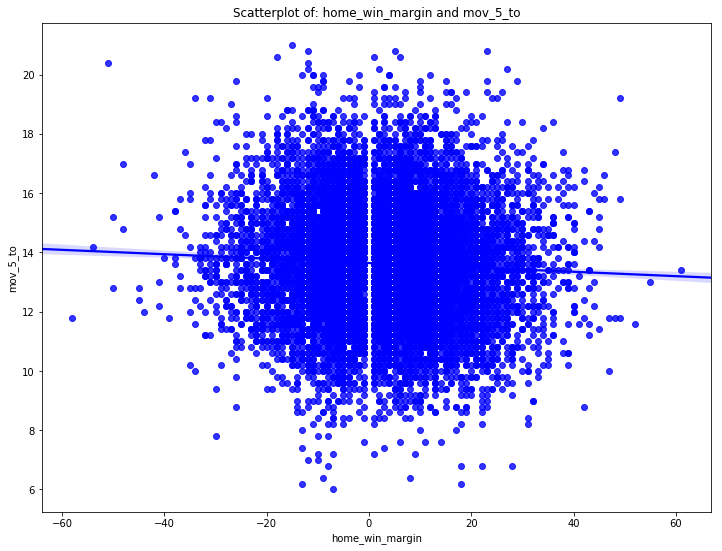

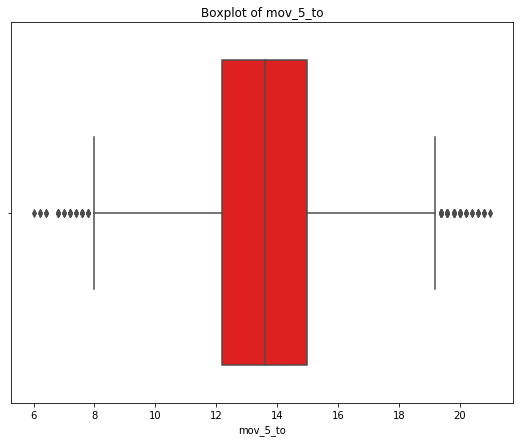

In [316]:
graph.plothist('mov_5_to')
graph.plotscat('home_win_margin','mov_5_to')
graph.plotbox('mov_5_to')

In [317]:
nba.mov_5_away_turnovers

5        16.6
7        17.0
8        17.0
9        16.2
10       17.0
11       18.0
12       17.0
13       17.4
14       16.8
15       15.8
16       15.8
17       15.0
18       14.4
19       15.2
20       15.4
21       15.0
22       15.8
23       14.6
24       14.0
25       13.8
26       12.8
27       13.0
28       15.0
30       15.8
31       15.8
32       15.0
33       13.6
34       15.4
35       15.8
37       18.0
         ... 
14077    12.0
14078    11.8
14079    10.4
14080    10.0
14081    11.2
14082    10.6
14083    10.6
14084    11.4
14085    12.6
14086    12.6
14087    13.4
14088    13.2
14089    13.4
14090    13.0
14091    12.6
14092    12.8
14093    12.6
14094    11.8
14095    11.2
14096    11.4
14097    11.8
14098    13.4
14099    13.8
14100    14.6
14101    15.4
14102    15.8
14103    15.0
14104    15.0
14105    14.6
14106    13.0
Name: mov_5_away_turnovers, Length: 12145, dtype: float64

/Users/bryancombs/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


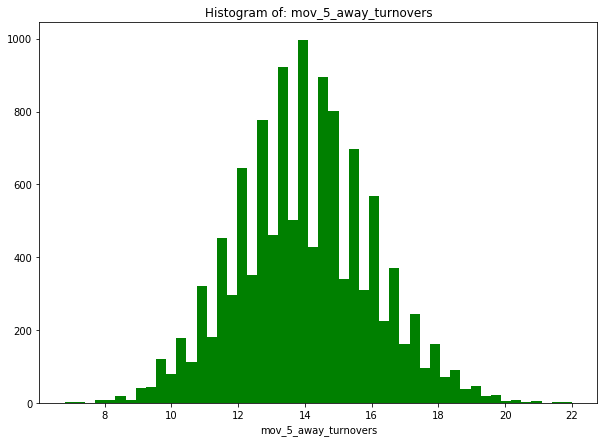

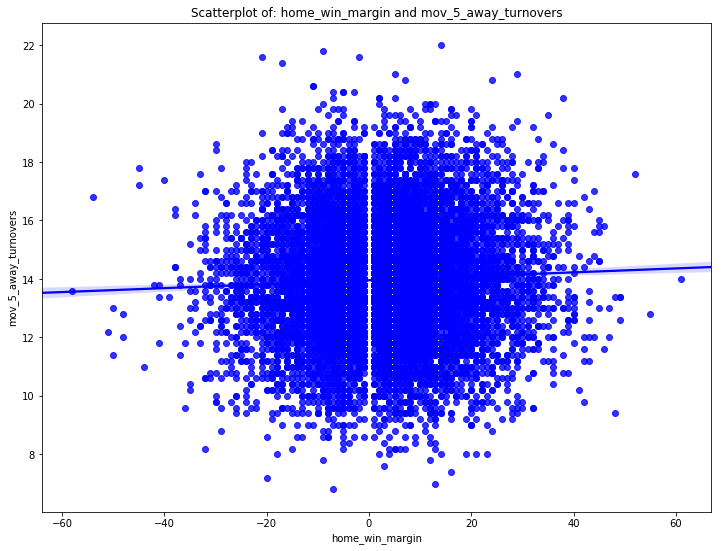

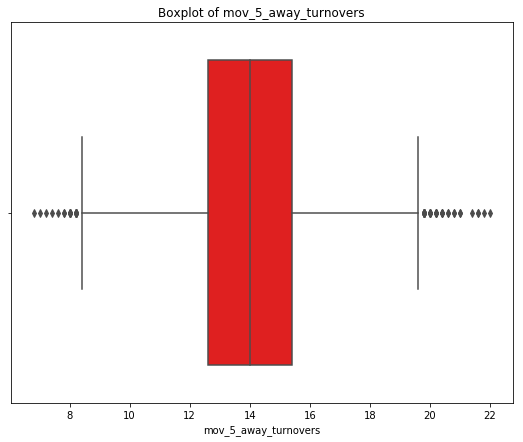

In [318]:
graph.plothist('mov_5_away_turnovers')
graph.plotscat('home_win_margin','mov_5_away_turnovers')
graph.plotbox('mov_5_away_turnovers')

/Users/bryancombs/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


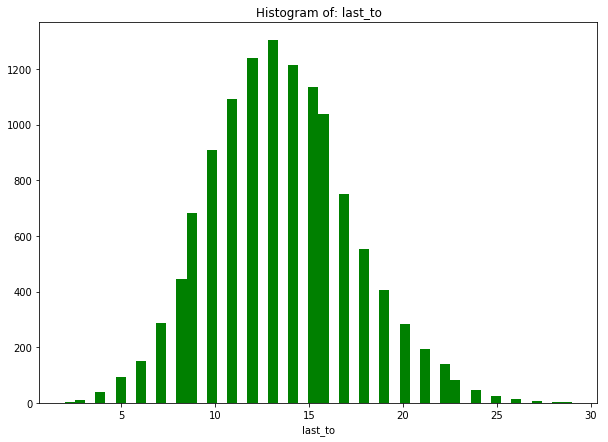

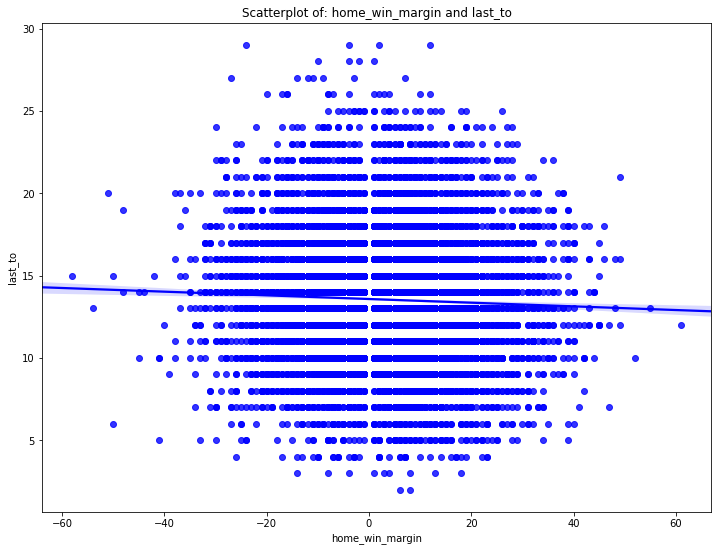

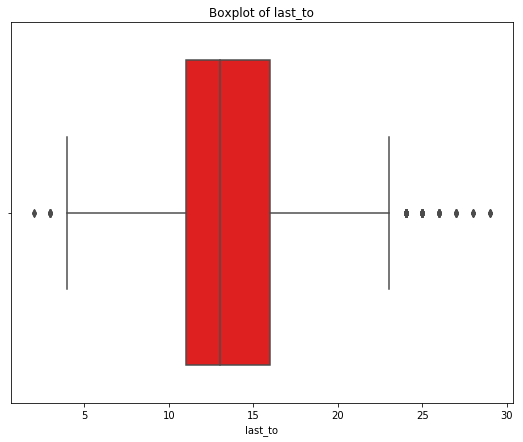

In [319]:
graph.plothist('last_to')
graph.plotscat('home_win_margin','last_to')
graph.plotbox('last_to')

/Users/bryancombs/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


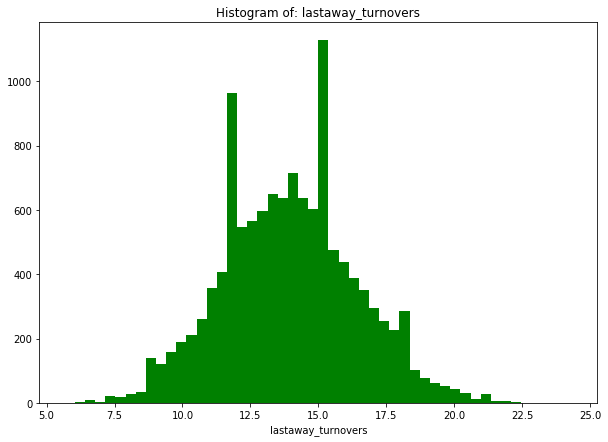

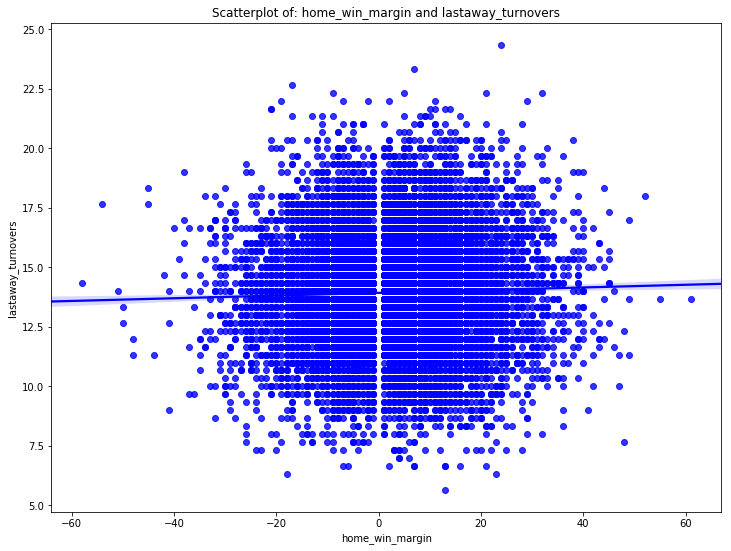

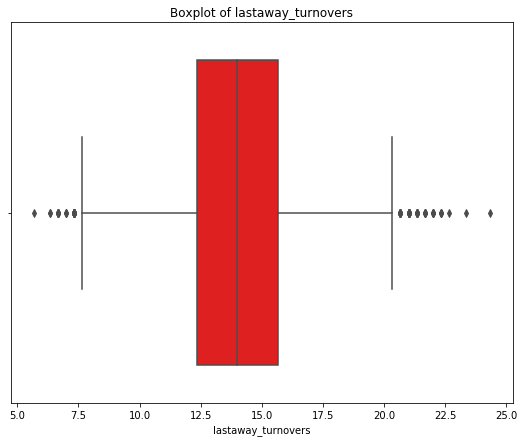

In [320]:
graph.plothist('lastaway_turnovers')
graph.plotscat('home_win_margin','lastaway_turnovers')
graph.plotbox('lastaway_turnovers')

/Users/bryancombs/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


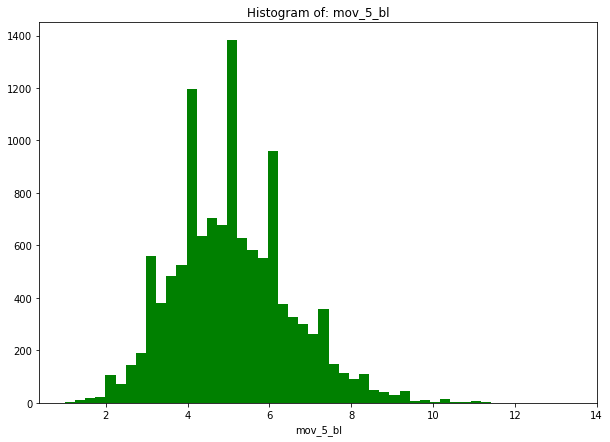

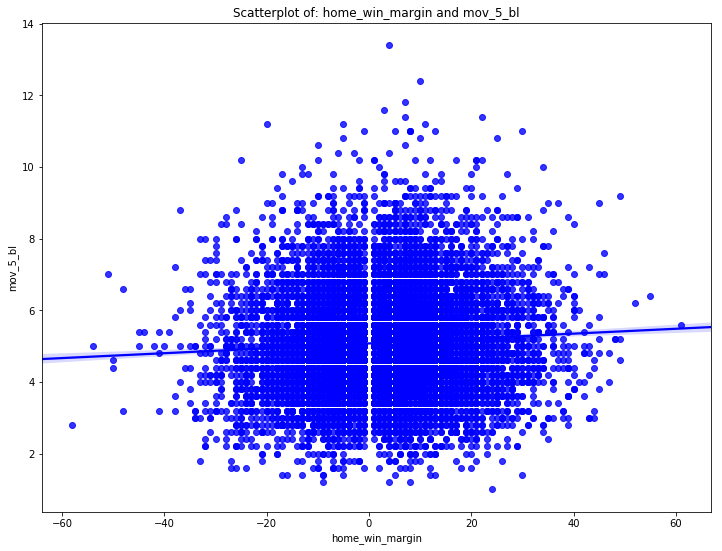

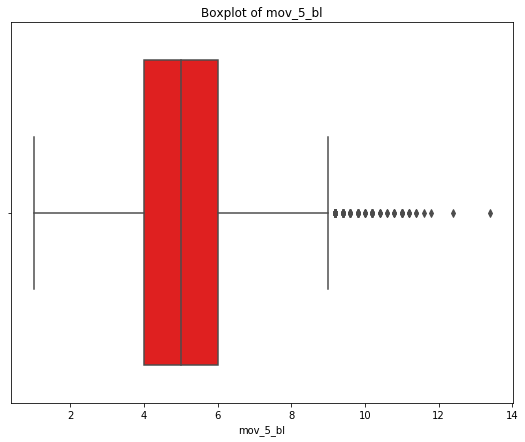

In [321]:
graph.plothist('mov_5_bl')
graph.plotscat('home_win_margin','mov_5_bl')
graph.plotbox('mov_5_bl')

/Users/bryancombs/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


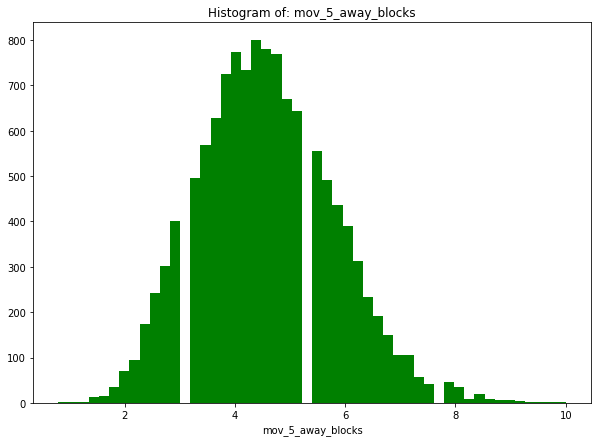

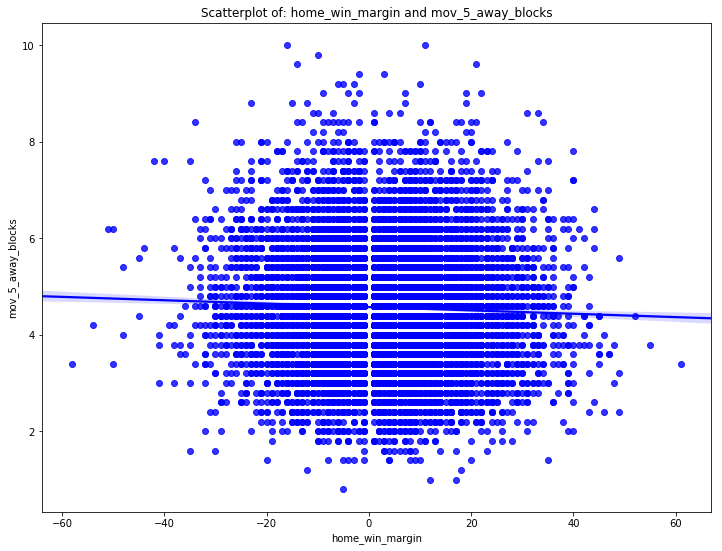

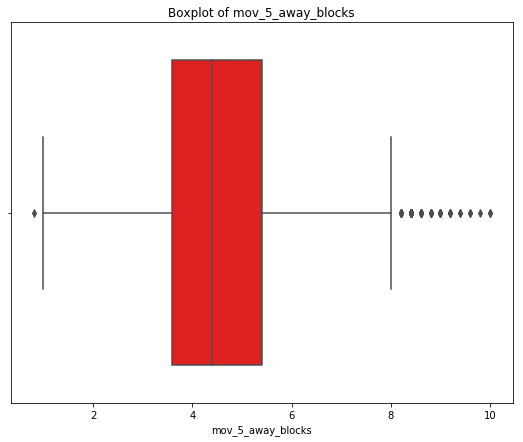

In [322]:
graph.plothist('mov_5_away_blocks')
graph.plotscat('home_win_margin','mov_5_away_blocks')
graph.plotbox('mov_5_away_blocks')

/Users/bryancombs/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


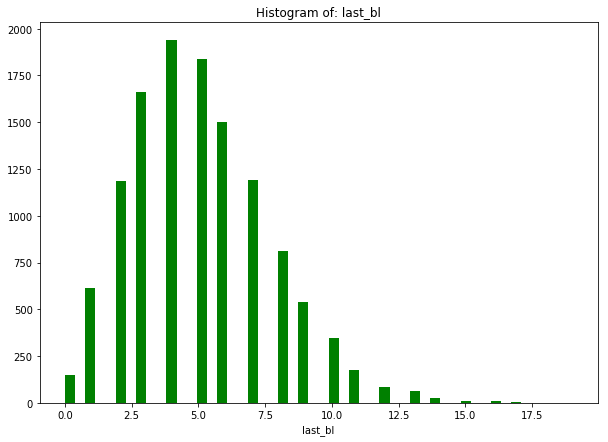

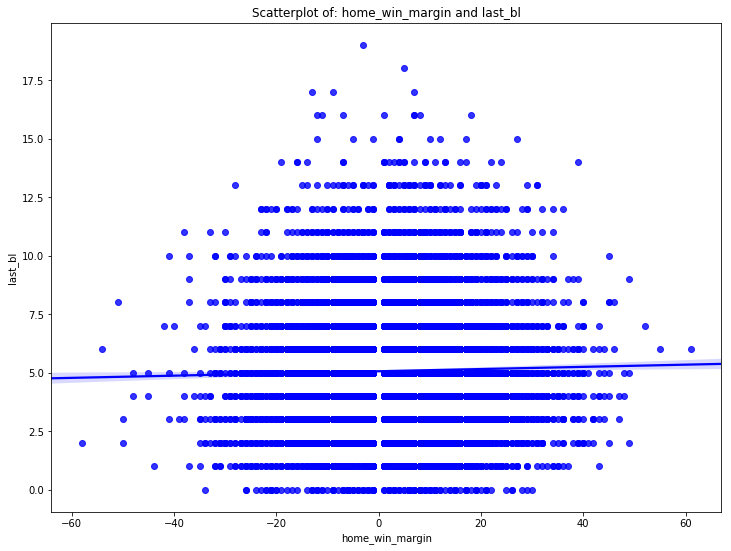

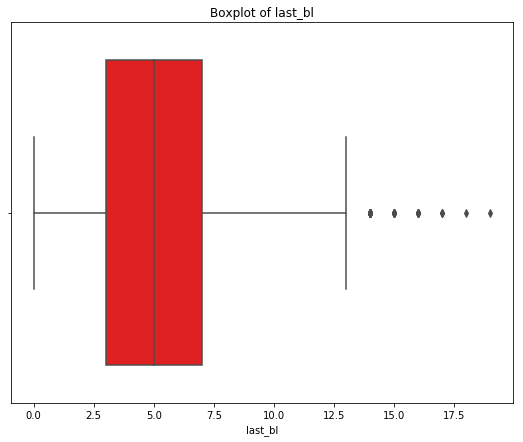

In [323]:
graph.plothist('last_bl')
graph.plotscat('home_win_margin','last_bl')
graph.plotbox('last_bl')

/Users/bryancombs/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


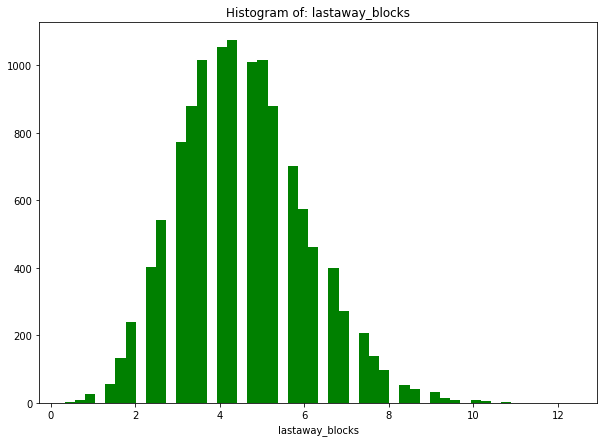

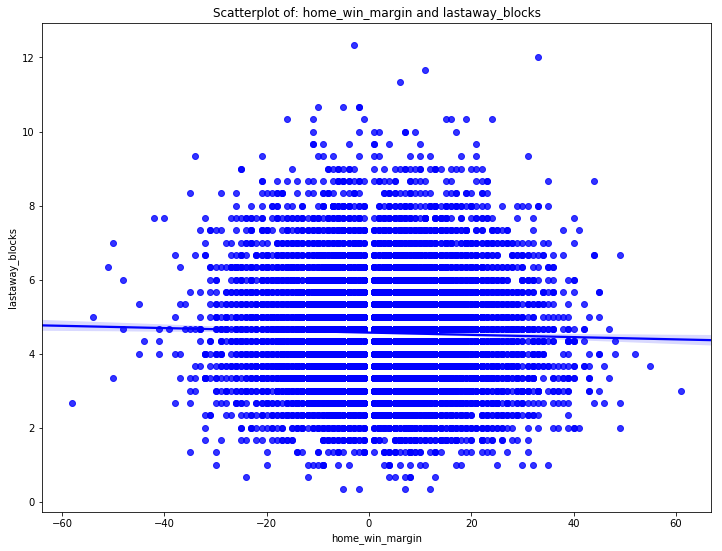

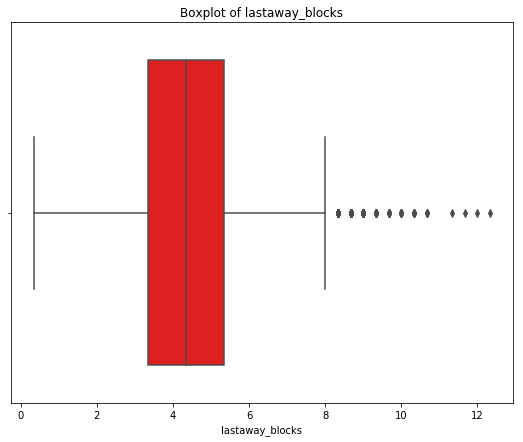

In [324]:
graph.plothist('lastaway_blocks')
graph.plotscat('home_win_margin','lastaway_blocks')
graph.plotbox('lastaway_blocks')

#### Skewed Data

You will notice that most of the game statistics data has a right tail of outliers.  I tested box cox transformations on the data to normalize the data, but it had no impact on the results so I left the
data in its original form. 

In [325]:
# nba.mov_5_dr,       _  = boxcox(nba.mov_5_dr)
# nba.mov_5_or,       _  = boxcox(nba.mov_5_or)
# nba.last_dr,        _  = boxcox(nba.last_dr)
# nba.lastaway_dr,    _  = boxcox(nba.lastaway_dr)
# nba.mov_5_3pa,      _  = boxcox(nba.mov_5_3pa)
# nba.last_3pa,       _  = boxcox(nba.last_3pa)
# nba.mov_5_away_3pa, _  = boxcox(nba.mov_5_away_3pa)
# nba.mov_5_fga,      _  = boxcox(nba.mov_5_fga)
# nba.mov_5_away_fga, _  = boxcox(nba.mov_5_away_fga)
# nba.last_fga,       _  = boxcox(nba.last_fga)
# nba.lastaway_fga,   _  = boxcox(nba.lastaway_fga)
# nba.mov_5_bl,       _  = boxcox(nba.mov_5_bl)
# nba.mov_5_away_bl,  _  = boxcox(nba.mov_5_away_bl)

### Playoff Games

Currently, the data sets contain both regular season and playoff games.  Here I create a feature dummy variable that indicates the game is a playoff game.

In [326]:
nba['playoff_game'] = nba.dataset.map(lambda x:1 if x[5] =='P' else 0)

In [327]:
nba.playoff_game.value_counts()

0    11284
1      861
Name: playoff_game, dtype: int64

/Users/bryancombs/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


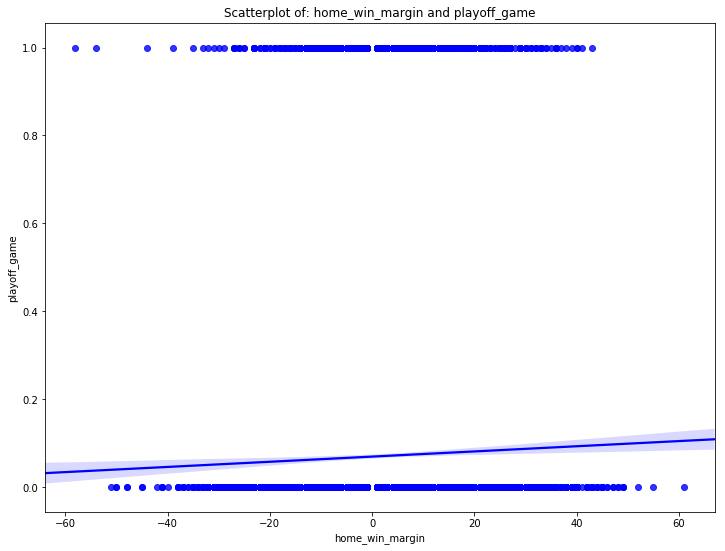

In [328]:
graph.getdata(nba)

graph.plotscat('home_win_margin', 'playoff_game')

### Conference games

In [329]:

eastern =  ['Atlanta', 'Boston', 'Charlotte', 'Cleveland', 'Detroit',
            'Miami', 'Indiana', 'Washington', 'Chicago', 'Orlando', 
            'Toronto', 'Milwaukee', 'Philadelphia', 'New_York', 
            'New_Jersey']

nba['home_conference'] = nba.teams.map(lambda x:
                                       1 if x in eastern else 0)
nba['away_conference'] = nba.away_team.map(lambda x:
                                       1 if x in eastern else 0)
nba['in_conference_game'] = nba['home_conference'] + nba['away_conference']     

In [330]:
nba.in_conference_game.replace({0:1, 1:0, 2:1}, inplace = True)

/Users/bryancombs/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


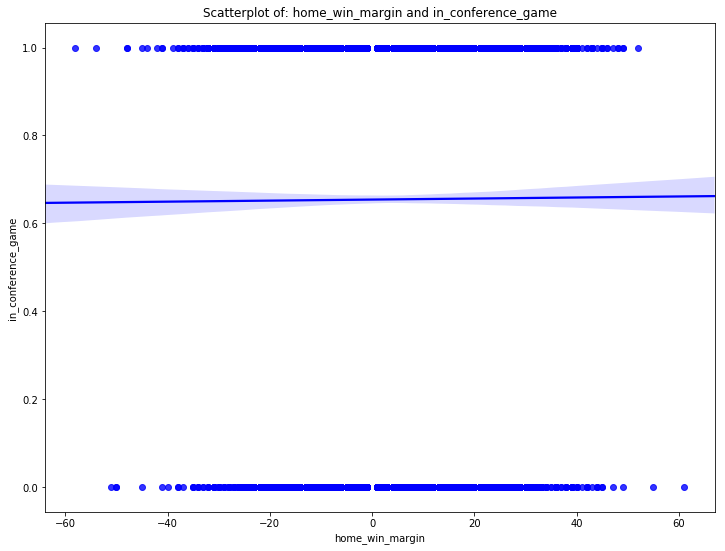

In [331]:
graph.getdata(nba)

graph.plotscat('home_win_margin', 'in_conference_game')

### Problem with Traditional Metrics

Our first models concentrated on traditional metrics such as scoring and effeciency numbers did not have any explanatory power in predicting the spread.  Some of this is due to the fact that the spread is created using these numbers so they do not predict better than the spread.  So while I will keep some of these variable in the model. I want to look for subsets of the data that the model might not predict as well.  The first subset that I chose was playoff games.  The spread does not predict playoff games nearly as well as regular season. The difference between the average win margin and the spread is .7 almost twice as high as the normal line.  In addition the advantage is for home teams and the home team covers over 52% of the time.  

This make theoretical sense as betting public generally likes to bet the favorites. They think that a better team will win on the road even if that is not born out by statistics.  I will take this subset of data and see if I can predict this better than the spread.   

In [332]:
print(nba[nba.playoff_game == 1].home_win_margin.mean())
print(nba[nba.playoff_game == 1].cover.mean())
np.std(nba[nba.playoff_game ==1].home_win_margin)

4.502903600464576
0.521486643437863


14.021687314526012

In [333]:
print(nba[nba.playoff_game == 1].spread.mean())
np.std(nba[nba.playoff_game == 1].spread)

-3.8397212543554007


4.887215958946939

In [334]:
nba1 = nba[nba.playoff_game == 1]

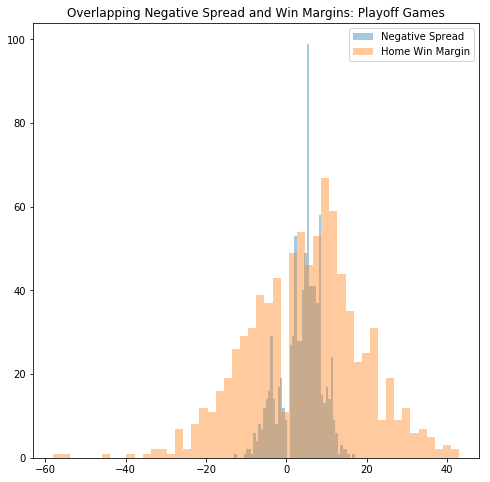

In [335]:
fig = plt.figure(figsize= (8,8))
plt.hist(-nba1.spread, bins=50, alpha=0.4, label='Negative Spread')
plt.hist(nba1.home_win_margin, bins=50, alpha=0.4, label='Home Win Margin')
plt.legend(loc='upper right')
plt.title("Overlapping Negative Spread and Win Margins: Playoff Games")
plt.show()

Bigger numbers are more common in the playoffs. This makes sense as teams do not give up as easily as they do in the regular season

In [336]:
nba1.home_win_margin.value_counts(normalize=True)

 10.0    0.040650
 9.0     0.037166
 2.0     0.034843
 4.0     0.034843
 12.0    0.034843
 11.0    0.033682
 8.0     0.033682
-4.0     0.030197
 13.0    0.030197
 5.0     0.029036
 7.0     0.027875
 3.0     0.027875
-2.0     0.026713
 15.0    0.024390
 6.0     0.024390
-3.0     0.023229
-6.0     0.023229
 21.0    0.023229
 1.0     0.022067
-7.0     0.022067
 14.0    0.020906
-8.0     0.020906
-10.0    0.019744
 19.0    0.019744
-13.0    0.017422
-14.0    0.016260
 16.0    0.016260
-9.0     0.015099
 18.0    0.013937
-11.0    0.013937
           ...   
-19.0    0.005807
-15.0    0.005807
-27.0    0.004646
 24.0    0.004646
 36.0    0.004646
 32.0    0.003484
 31.0    0.003484
-26.0    0.003484
-20.0    0.002323
 40.0    0.002323
 34.0    0.002323
-22.0    0.002323
-25.0    0.002323
-39.0    0.001161
-33.0    0.001161
-44.0    0.001161
 38.0    0.001161
-54.0    0.001161
-35.0    0.001161
-32.0    0.001161
-31.0    0.001161
 37.0    0.001161
-30.0    0.001161
-29.0    0.001161
 28.0    0

In [337]:
nba.to_csv('./data/nba_analysis_data.csv', index = False)


### Looking at Total Data for Future Analysis

In [338]:
print(nba.over.mean())
print(nba[nba.playoff_game == 1].over.mean())
np.std(nba[nba.playoff_game ==1].home_win_margin)

0.49444215726636476
0.5203252032520326


14.021687314526012

In [339]:
print(nba[nba.playoff_game == 1].total.median())
print(np.std(nba.total))

193.5
11.583861920218494


In [340]:
print(nba.total_diff.median())
np.std(nba.total_diff)

0.0


17.623321281939045

In [341]:
print(nba[nba.playoff_game == 1]['total_score'].median ())
np.std(nba.total_score)

194.0


20.782930957150413